In [92]:
import os

from typing import (
    List,
    Union,
    Tuple, 
    Dict,
    Callable,
    Optional,
    Literal
)

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from skimpy import skim
import missingno as msno

import optuna

from sklearn.base import (
    BaseEstimator,
    ClassifierMixin
)
from sklearn.compose import (
    ColumnTransformer,
    make_column_transformer)
from sklearn.pipeline import (
    Pipeline,
    make_pipeline
)
from sklearn.ensemble import (
    RandomForestClassifier,
    StackingClassifier
)
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import (
    train_test_split,
    learning_curve,
    cross_validate,
    cross_val_score
)                                    
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score,
    roc_curve,
    f1_score,
    matthews_corrcoef,
    roc_auc_score,
    confusion_matrix,
    precision_score,
    recall_score
)

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier

import warnings
from tqdm.auto import tqdm

warnings.filterwarnings('ignore')
os.environ['PYTHONWARNINGS'] = 'ignore'
optuna.logging.set_verbosity(optuna.logging.ERROR)
tqdm.pandas()
plt.style.use('ggplot')

In [93]:
data = pd.read_csv('train.csv')

In [94]:
data.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [95]:
skim(data)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 140700 │ │ string      │ 10    │                                                          │
│ │ Number of columns │ 20     │ │ float64     │ 8     │                                                          │
│ └───────────────────┴────────┘ │ int64       │ 2     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name         ┃ NA      ┃ NA %   ┃ mean   ┃ sd     ┃ p0   ┃ p25   ┃ p50   ┃ p75    ┃ p100   ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━┩  │
│ │ id                  │       0 │      0 │  70350 │  40620 │    0 │ 35170 │ 70350 │ 105500 │ 140700 │ ▇▇▇▇▇▇ │  │
│ │ Age                 │       0 │      0 │  40.39 │  12.38 │   18 │    29 │    42 │     51 │     60 │ ▆▅▅▆▇▇ │  │
│ │ Academic Pressure   │  112803 │  80.17 │  3.142 │   1.38 │    1 │     2 │     3 │      4 │      5 │ ▅▅ ▇▆▇ │  │
│ │ Work Pressure       │   27918 │  19.84 │  2.999 │  1.406 │    1 │     2 │     3 │      4 │      5 │ ▇▇ ▇▇▇ │  │
│ │ CGPA                │  112802 │  80.17 │  7.659 │  1.464 │ 5.03 │  6.29 │  7.77 │   8.92 │     10 │ ▇▅▇▇▇▇ │  │
│ │ Study Satisfaction  │  112803 │  80.17 │  2.945 │   1.36 │    1 │     2 │     3 │      4 │      5 │ ▇▇ ▇▇▆ │  │
│ │ Job Satisfaction    │   27910 │  19.84 │  2.974 │  1.416 │    1 │     2 │     3 │      4 │      5 │ ▇▇ ▇▇▇ │  │
│ │ Work/Study Hours    │       0 │      0 │  6.253 │  3.854 │    0 │     3 │     6 │     10 │     12 │ ▅▅▃▅▅▇ │  │
│ │ Financial Stress    │       4 │      0 │  2.989 │  1.414 │    1 │     2 │     3 │      4 │      5 │ ▇▇ ▇▇▇ │  │
│ │ Depression          │       0 │      0 │ 0.1817 │ 0.3856 │    0 │     0 │     0 │      0 │      1 │ ▇    ▂ │  │
│ └─────────────────────┴─────────┴────────┴────────┴────────┴──────┴───────┴───────┴────────┴────────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                        ┃ NA         ┃ NA %       ┃ words per row          ┃ total words        ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩  │
│ │ Name                               │          0 │          0 │                      1 │             140702 │  │
│ │ Gender                             │          0 │          0 │                      1 │             140700 │  │
│ │ City                               │          0 │          0 │                      1 │             140704 │  │
│ │ Working Professional or Student    │          0 │          0 │                    1.8 │             253499 │  │
│ │ Profession                         │      36630 │      26.03 │                      1 │             144073 │  │
│ │ Sleep Duration                     │          0 │          0 │                      3 │             424406 │  │
│ │ Dietary Habits                     │          4 │   

In [96]:
data = data.drop(['id', 'Name'], axis=1)

In [97]:
def plot_target_distribution(df: pd.DataFrame,
                             target: str) -> None:
    """
    Plot the distribution of the target variable.

    :param df: The dataset.
    :param target: The target variable.
    """

    df[target].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, explode=[0, 0.1])
    plt.ylabel('')
    plt.title('Target distribution')
    plt.show()

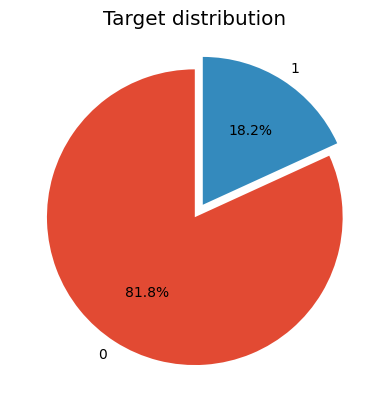

In [98]:
TARGET_COL = 'Depression'
plot_target_distribution(data, TARGET_COL)

In [99]:
def plot_cumulative_percentage(df: pd.DataFrame,
                               col: str,
                               ax: plt.Axes) -> None:
    """
    Plot the cumulative percentage of each category in a categorical column
    """

    df[col].value_counts(normalize=True).sort_values(ascending=False).cumsum().plot(kind='bar', ax=ax)

In [100]:
data_categorical_cols = data.select_dtypes(include='object').columns
data_numerical_cols = data.select_dtypes(exclude='object').columns

assert len(data_categorical_cols) + len(data_numerical_cols) == data.shape[1]

In [101]:
print(f'Number of categorical columns: {len(data_categorical_cols)}')
print(f'Number of numerical columns: {len(data_numerical_cols)}')

Number of categorical columns: 9
Number of numerical columns: 9


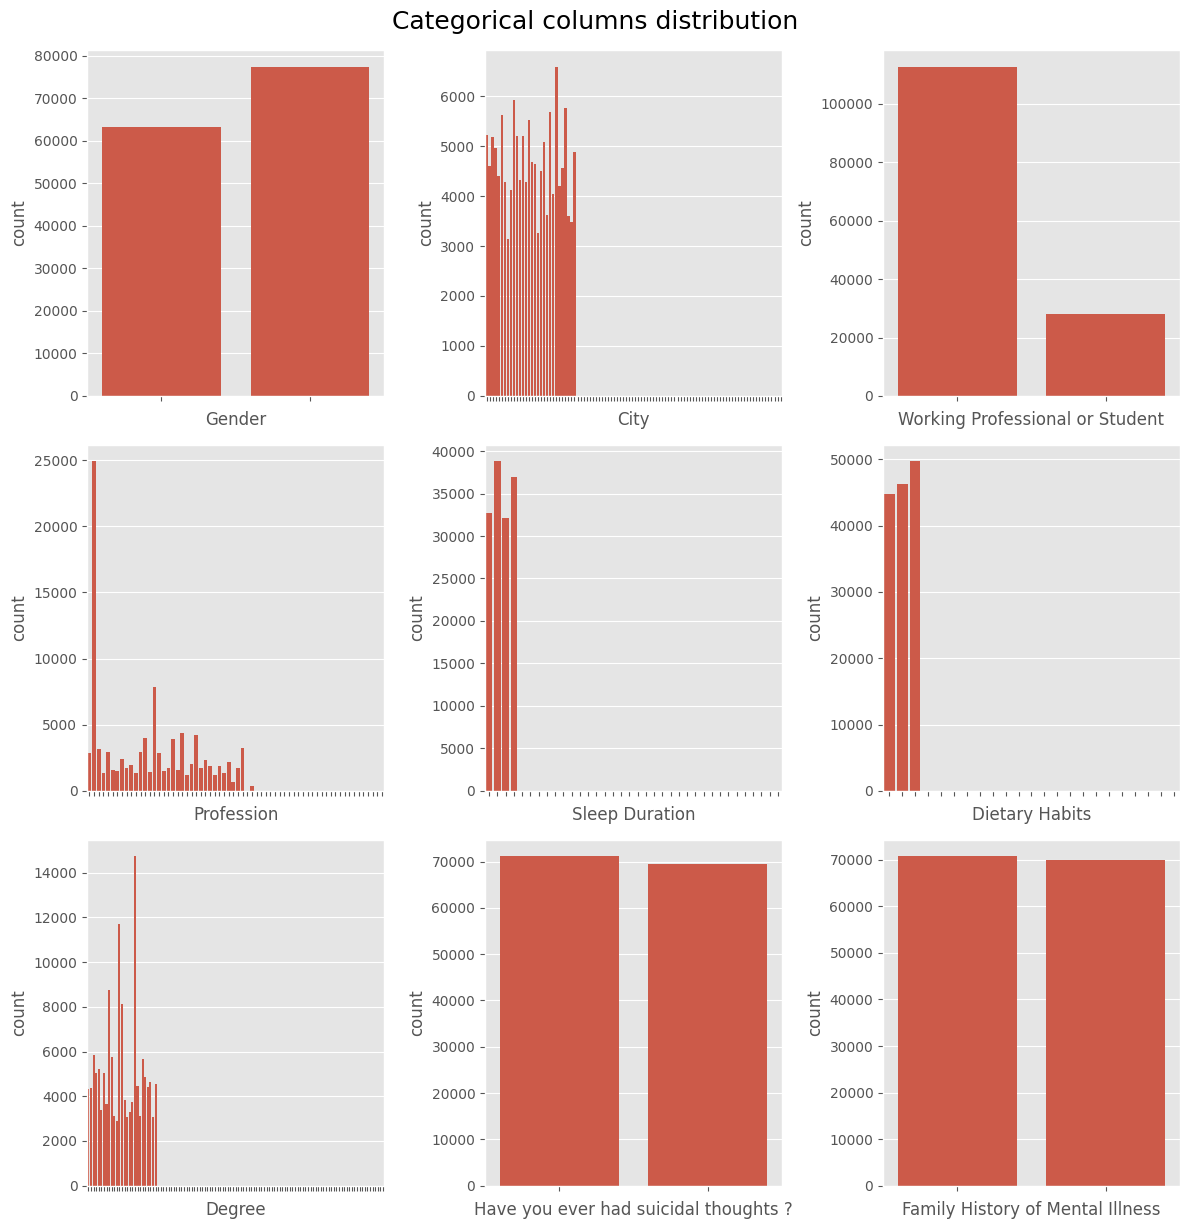

In [106]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for i, col in enumerate(data_categorical_cols):
    sns.countplot(data=data, x=col, ax=axes[i // 3, i % 3])
    axes[i // 3, i % 3].set_xticklabels([])

plt.tight_layout()
fig.suptitle('Categorical columns distribution', y=1.02, size=18)
plt.show()

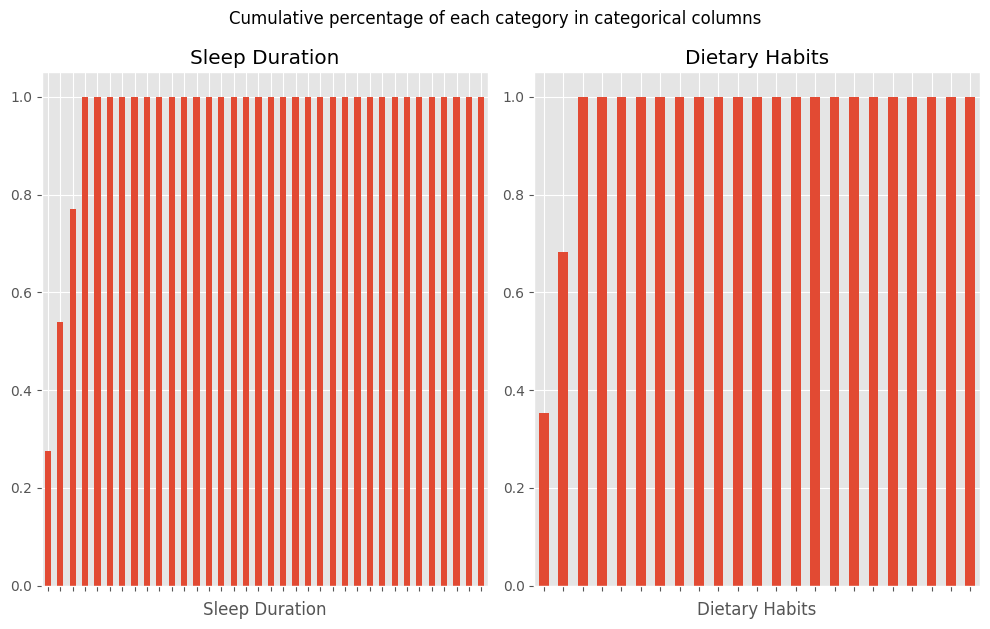

In [117]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

data["Sleep Duration"].value_counts(normalize=True).sort_values(ascending=False).cumsum().plot(kind='bar', ax=axes[0])
data["Dietary Habits"].value_counts(normalize=True).sort_values(ascending=False).cumsum().plot(kind='bar', ax=axes[1])

axes[0].set_xticklabels([])
axes[1].set_xticklabels([])

axes[0].set_title('Sleep Duration')
axes[1].set_title('Dietary Habits')

plt.tight_layout()
fig.suptitle('Cumulative percentage of each category in categorical columns', y=1.04, size=12)
plt.show()

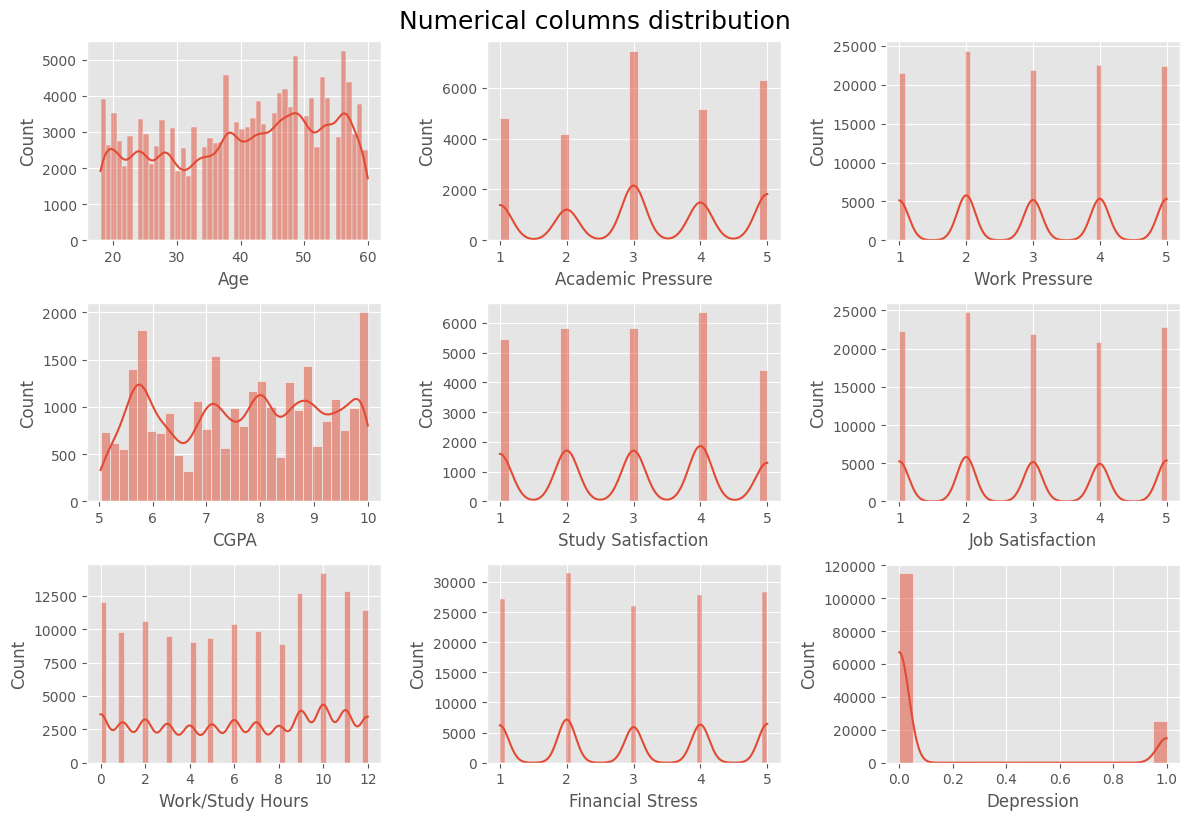

In [105]:
fig, axes = plt.subplots(3, 3, figsize=(12, 8))

for i, col in enumerate(data_numerical_cols):
    sns.histplot(data[col], ax=axes[i // 3, i % 3], kde=True)

plt.tight_layout()
fig.suptitle('Numerical columns distribution', y=1.02, size=18)
plt.show()

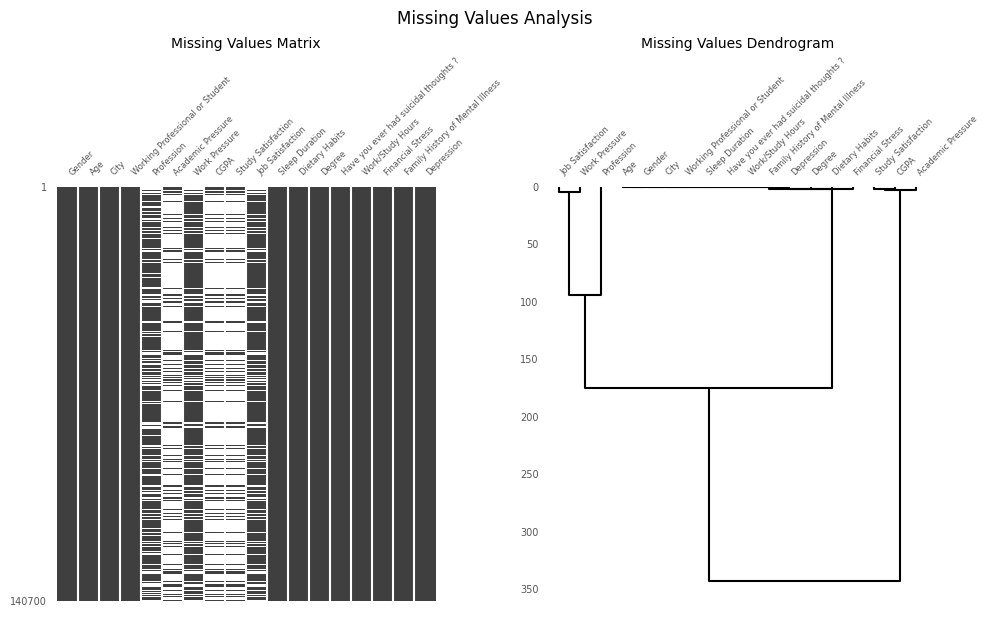

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

plt.sca(axes[0])
msno.matrix(data, sparkline=False, ax=axes[0], fontsize=6)
axes[0].set_title('Missing Values Matrix', fontsize=10)

plt.sca(axes[1])
msno.dendrogram(data, ax=axes[1], fontsize=6)
axes[1].set_title('Missing Values Dendrogram', fontsize=10)

plt.tight_layout()
fig.suptitle('Missing Values Analysis', y=1.02, size=12)
plt.show()

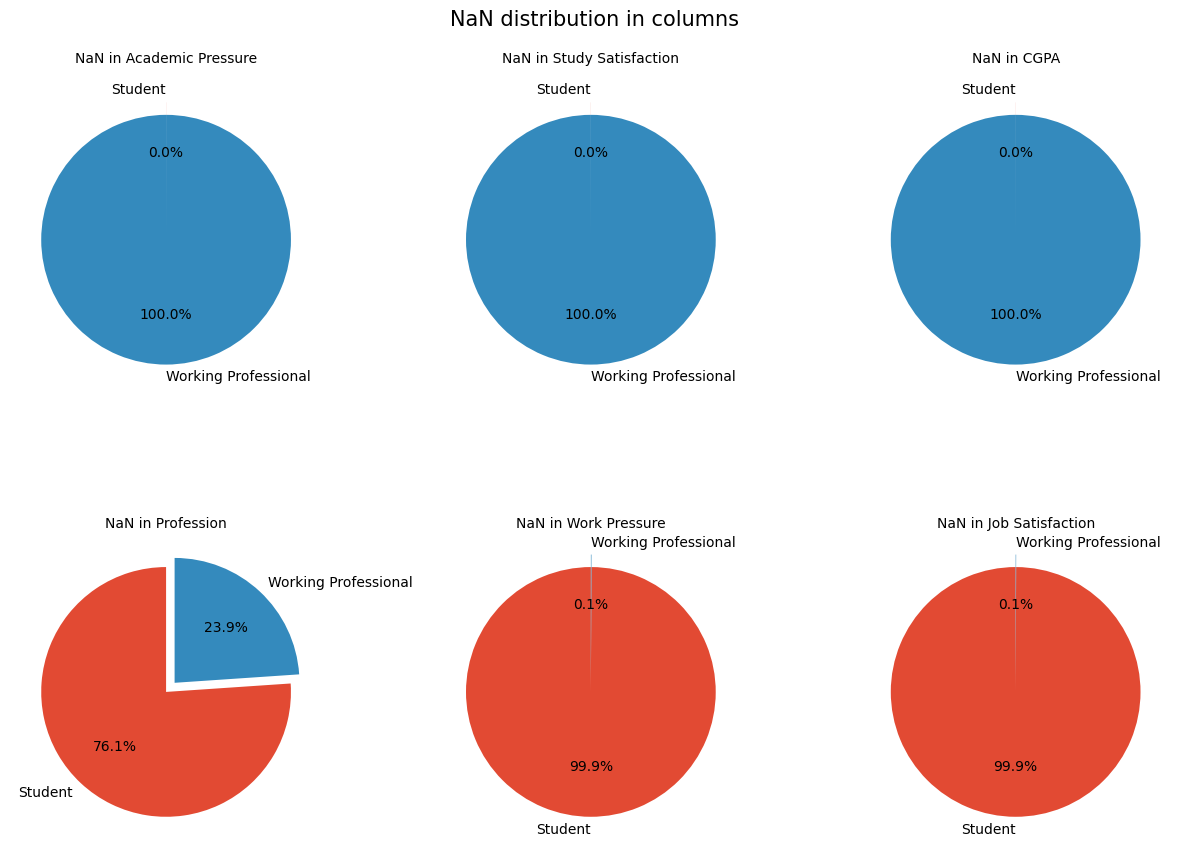

In [14]:
COL_WITH_NA_SORTED = ['Academic Pressure', 'Study Satisfaction', 'CGPA', 'Profession', 'Work Pressure', 'Job Satisfaction']

fig, axes = plt.subplots(2, 3, figsize=(12, 10))
axes = axes.flatten()

for i, col in enumerate(COL_WITH_NA_SORTED):
    counts = data.groupby('Working Professional or Student')[col].apply(lambda x: x.isna().sum())
    
    axes[i].pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90, explode=[0, 0.1])
    axes[i].set_title(f'NaN in {col}', fontsize=10)

plt.tight_layout()
fig.suptitle('NaN distribution in columns', y=0.95, size=15)
plt.show()


In [15]:
data_student = data[data['Working Professional or Student'] == 'Student']
data_professional = data[data['Working Professional or Student'] == 'Working Professional']

In [16]:
skim(data_student)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 27901  │ │ string      │ 9     │                                                          │
│ │ Number of columns │ 18     │ │ float64     │ 8     │                                                          │
│ └───────────────────┴────────┘ │ int64       │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name           ┃ NA     ┃ NA %   ┃ mean    ┃ sd      ┃ p0    ┃ p25   ┃ p50   ┃ p75  ┃ p100 ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━╇━━━━━━━━┩  │
│ │ Age                   │      0 │      0 │   25.82 │   4.906 │    18 │    21 │    25 │   30 │   59 │  ▇▇▃   │  │
│ │ Academic Pressure     │      9 │   0.03 │   3.142 │   1.381 │     1 │     2 │     3 │    4 │    5 │ ▅▅ ▇▆▇ │  │
│ │ Work Pressure         │  27898 │  99.99 │       4 │   1.732 │     2 │   3.5 │     5 │    5 │    5 │ ▃    ▇ │  │
│ │ CGPA                  │      9 │   0.03 │   7.659 │   1.464 │  5.03 │  6.29 │  7.77 │ 8.92 │   10 │ ▇▅▇▇▇▇ │  │
│ │ Study Satisfaction    │     10 │   0.04 │   2.945 │    1.36 │     1 │     2 │     3 │    4 │    5 │ ▇▇ ▇▇▆ │  │
│ │ Job Satisfaction      │  27893 │  99.97 │   2.375 │   1.188 │     1 │  1.75 │     2 │ 3.25 │    4 │ ▅ ▇ ▃▅ │  │
│ │ Work/Study Hours      │      0 │      0 │   7.157 │   3.708 │     0 │     4 │     8 │   10 │   12 │ ▂▂▂▃▃▇ │  │
│ │ Financial Stress      │      3 │   0.01 │    3.14 │   1.437 │     1 │     2 │     3 │    4 │    5 │ ▆▆ ▆▇▇ │  │
│ │ Depression            │      0 │      0 │  0.5855 │  0.4926 │     0 │     0 │     1 │    1 │    1 │ ▆    ▇ │  │
│ └───────────────────────┴────────┴────────┴─────────┴─────────┴───────┴───────┴───────┴──────┴──────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                        ┃ NA         ┃ NA %       ┃ words per row          ┃ total words        ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩  │
│ │ Gender                             │          0 │          0 │                      1 │              27901 │  │
│ │ City                               │          0 │          0 │                      1 │              27905 │  │
│ │ Working Professional or Student    │          0 │          0 │                      1 │              27901 │  │
│ │ Profession                         │      27867 │      99.88 │                 0.0015 │                 42 │  │
│ │ Sleep Duration                     │          0 │          0 │                      3 │              84509 │  │
│ │ Dietary Habits                     │          2 │       0.01 │                      1 │              27903 │  │
│ │ Degree                             │          0 │          0 │                    1.2 │              33983 │  │
│ │ Have you ever had suicidal         │          0 │   

In [17]:
data_student = data_student.drop(['Working Professional or Student', 'Work Pressure', 'Job Satisfaction', 'Profession'], axis=1)

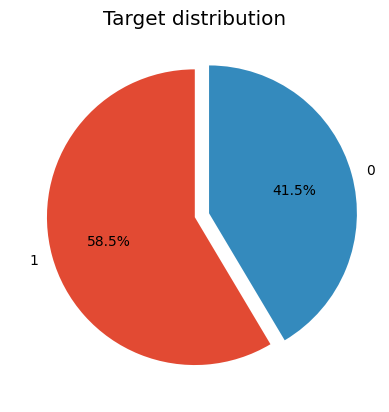

In [18]:
plot_target_distribution(data_student, TARGET_COL)

In [19]:
TOTAL_NA_OVER_AXIS_0 = data_student.isna().sum(axis=0)

print(f'Proportion of missing values in the student dataset: {TOTAL_NA_OVER_AXIS_0.sum() / data_student.shape[0]:5f}')

Proportion of missing values in the student dataset: 0.001183


In [20]:
data_student = data_student.dropna()

In [21]:
X_student = data_student.drop(TARGET_COL, axis=1)
y_student = data_student[TARGET_COL]

In [22]:
print("Student dataset shape:", X_student.shape)
print("Student target shape:", y_student.shape)

Student dataset shape: (27882, 13)
Student target shape: (27882,)


In [23]:
def plot_categorical_count(df: pd.DataFrame,
                           ax: plt.Axes) -> None:
     """
     Plot the count of categories in each categorical column in a specific axis.
    
     :param df: The dataframe to plot.
     :param ax: The axis to plot the histogram.
     """
    
     counts = df.select_dtypes(include='object').nunique().sort_values(ascending=False)
     sns.barplot(x=counts, y=counts.index, ax=ax)
     ax.set_ylabel('')
     ax.set_xlabel('')
     ax.set_title('Number of categories per column')

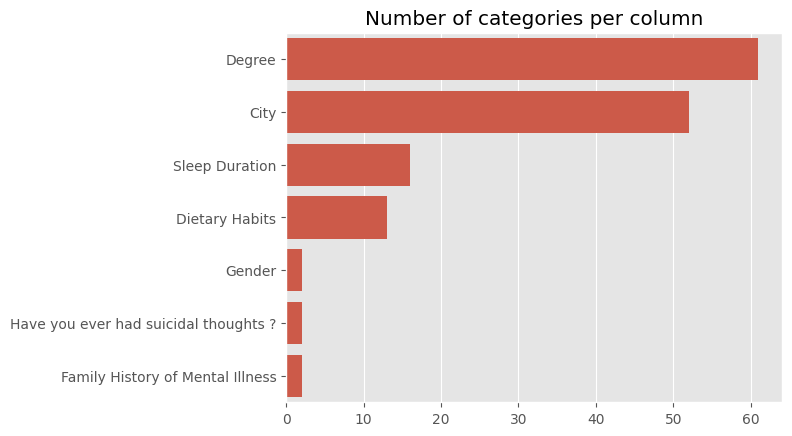

In [24]:
plot_categorical_count(X_student, plt.gca())
plt.show()

In [25]:
print(f"Sleep Duration categories: \n\n{X_student['Sleep Duration'].unique()}", end='\n\n')
print(f"Dietary Habits categories: \n\n{X_student['Dietary Habits'].unique()}")

Sleep Duration categories: 

['5-6 hours' 'Less than 5 hours' '7-8 hours' 'More than 8 hours'
 '1-2 hours' '10-11 hours' '40-45 hours' '2-3 hours' 'Moderate'
 '55-66 hours' '3-4 hours' '4-5 hours' '8 hours' '45' 'than 5 hours'
 '6-7 hours']

Dietary Habits categories: 

['Healthy' 'Moderate' 'Unhealthy' '3' 'Less than Healthy' 'Mihir' '1.0'
 'No Healthy' 'Less Healthy' 'M.Tech' 'Male' 'Yes' '2']


In [26]:
def clean_sleep_diet(X: pd.DataFrame, 
                     seed: int = 42) -> pd.DataFrame:
    """
    Clean the 'Sleep Duration' and 'Dietary Habits' columns.

    :param X: The dataframe to clean.
    :param seed: The random seed to use.
    :return: The cleaned dataframe.
    """

    np.random.seed(seed)

    X = X.copy()

    X['Sleep Duration'] = X['Sleep Duration'].progress_apply(
        lambda value: (
            0 if value in ["Less than 5 hours", "2-3 hours", "3-4 hours", "4-5 hours", "No"]
            else 1 if value in ["5-6 hours", "6-7 hours", "4-6 hours"]
            else 2 if value in ["7-8 hours"]
            else 3 if value in ["8-9 hours", "More than 8 hours", "9-11 hours", "10-11 hours"]
            else np.random.choice([0, 1, 2, 3])
        )
    )

    X['Dietary Habits'] = X['Dietary Habits'].progress_apply(
        lambda value: (
            0 if value in ["Unhealthy", "No Healthy", "No", "1", 1]
            else 1 if value in ["Moderate", "Less Healthy", "Less than Healthy", "2", 2]
            else 2 if value in ["Healthy", "More Healthy", "Yes", "3", 3]
            else np.random.choice([0, 1, 2])
        )
    )

    return X


In [27]:
X_student_cleaned = clean_sleep_diet(X_student)

  0%|          | 0/27882 [00:00<?, ?it/s]

  0%|          | 0/27882 [00:00<?, ?it/s]

In [28]:
X_student_cleaned, X_student_test, y_student, y_student_test = train_test_split(X_student_cleaned, y_student, test_size=0.2, random_state=42)
X_student_cleaned = X_student_cleaned.reset_index(drop=True)
y_student = y_student.reset_index(drop=True)
X_student_test = X_student_test.reset_index(drop=True)
y_student_test = y_student_test.reset_index(drop=True)

In [29]:
X_student_cleaned.head()

,Gender,Age,City,Academic Pressure,CGPA,Study Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness
0,Male,18.0,Bhopal,3.0,6.17,5.0,0,0,Class 12,No,5.0,1.0,No
1,Female,19.0,Agra,4.0,5.82,4.0,0,0,Class 12,Yes,7.0,4.0,No
2,Male,22.0,Varanasi,5.0,9.21,2.0,0,1,MSc,Yes,10.0,2.0,No
3,Male,34.0,Surat,2.0,5.68,4.0,3,1,B.Ed,Yes,0.0,1.0,No
4,Female,33.0,Kolkata,2.0,8.09,1.0,0,2,M.Com,No,5.0,3.0,Yes


In [30]:
print("Student dataset shape after PCA:", X_student_cleaned.shape)

Student dataset shape after PCA: (22305, 13)


In [69]:
basic_column_transformer = make_column_transformer(
    (OneHotEncoder(drop='first', handle_unknown='ignore', min_frequency=0.05),
     X_student_cleaned.select_dtypes(include='object').columns),
    remainder='passthrough',
    sparse_threshold=0
)

pca_pipeline = make_pipeline(
    basic_column_transformer,
    StandardScaler(),
    PCA(random_state=42)
)


X_student_pca = pca_pipeline.fit_transform(X_student_cleaned)


In [70]:
print("Student dataset shape after PCA:", X_student_pca.shape)

Student dataset shape after PCA: (27882, 17)


In [74]:
def plot_pca_analysis(pipeline: Pipeline,
                      X: pd.DataFrame,
                      y: pd.Series = None) -> None:
    """
    Plot the PCA analysis with the Kaiser criterion.

    :param pipeline: The pipeline to use.
    :param X: The features.
    :param y: The target.
    """

    X_pca = pipeline.fit_transform(X)
    
    pca_model = pipeline.named_steps['pca']
    components = pca_model.components_
    explained_variance = pca_model.explained_variance_ratio_
    total_components = len(explained_variance)
    kaiser_threshold = 1 / total_components

    preprocessor = pipeline.named_steps['columntransformer']
    encoder_feature_names = preprocessor.named_transformers_['onehotencoder'].get_feature_names_out(
        X.select_dtypes(include='object').columns
    )
    all_feature_names = list(encoder_feature_names) + list(X.select_dtypes(exclude='object').columns)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].hexbin(X_pca[:, 0], X_pca[:, 1], C=y, cmap='coolwarm', gridsize=50, alpha=0.5)
    axes[0].set_title('PCA Projection', fontsize=12)
    axes[0].set_xlabel('Principal Component 1')
    axes[0].set_ylabel('Principal Component 2')
    
    axes[1].axhline(0, color='grey', linestyle='--', linewidth=0.5)
    axes[1].axvline(0, color='grey', linestyle='--', linewidth=0.5)
    circle = plt.Circle((0, 0), 1, color='grey', fill=False, linestyle='--', linewidth=1.5)
    axes[1].add_artist(circle)
    for i, (x, y) in enumerate(zip(components[0], components[1])):
        axes[1].arrow(0, 0, x, y, color='r', alpha=0.8, head_width=0.03, length_includes_head=True)
        axes[1].text(x * 1.15, y * 1.15, all_feature_names[i], color='blue', fontsize=8, ha='center', va='center')
    axes[1].set_xlim(-1.2, 1.2)
    axes[1].set_ylim(-1.2, 1.2)
    axes[1].set_title('PCA Correlation Circle', fontsize=12)
    axes[1].set_xlabel('Principal Component 1')
    axes[1].set_ylabel('Principal Component 2')
    
    for i, var in enumerate(explained_variance):
        color = 'blue' if var > kaiser_threshold else 'gray'
        axes[2].bar(i + 1, var, alpha=0.7, align='center', color=color, label='Explained Variance' if i == 0 else None)
    axes[2].step(range(1, total_components + 1), np.cumsum(explained_variance), where='mid', label='Cumulative Variance')
    axes[2].axhline(kaiser_threshold, color='red', linestyle='--', label=f'Kaiser Threshold (1/{total_components:.0f})')
    axes[2].set_title('PCA Explained Variance', fontsize=12)
    axes[2].set_xlabel('Components')
    axes[2].set_ylabel('Variance Ratio')
    axes[2].legend(loc='best')
    
    plt.tight_layout()
    fig.suptitle('PCA Analysis', y=1.02, size=15)
    plt.show()

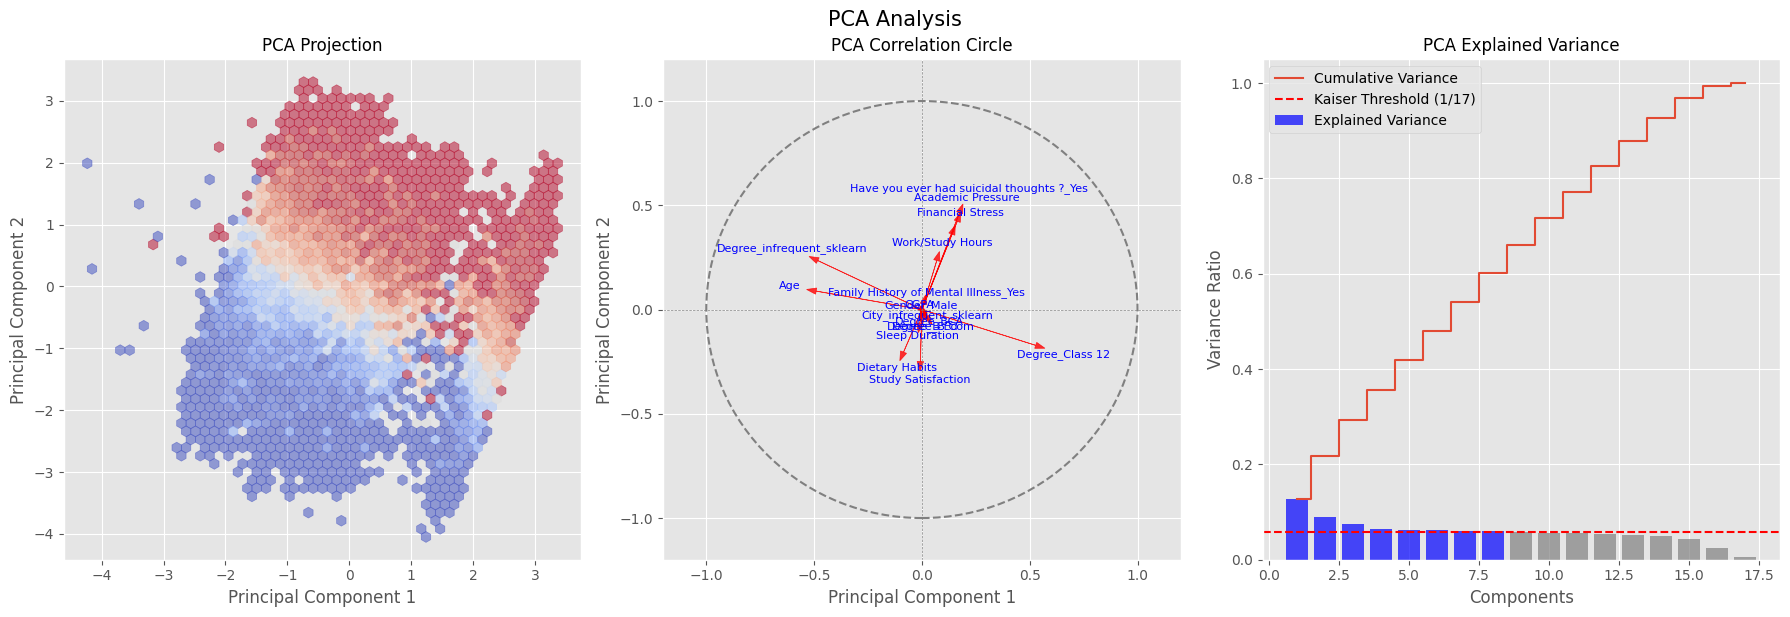

In [75]:
plot_pca_analysis(pca_pipeline, X_student_cleaned, y_student)

In [71]:
def plot_corr_matrix_encoded_data(pipeline: Pipeline,
                                  X: pd.DataFrame,
                                  ax: plt.Axes = None) -> pd.DataFrame:
    """
    Plot the correlation matrix of the encoded data.

    :param pipeline: The pipeline to use (must include preprocessing steps).
    :param X: The data to use.
    :param ax: The axis on which to plot the heatmap (optional).
    :return: The correlation matrix.
    """

    preprocessor = pipeline.named_steps['columntransformer']
    encoded_data = preprocessor.fit_transform(X)
    encoder_feature_names = preprocessor.named_transformers_['onehotencoder'].get_feature_names_out(
        X.select_dtypes(include='object').columns
    )
    all_feature_names = list(encoder_feature_names) + list(X.select_dtypes(exclude='object').columns)
    encoded_df = pd.DataFrame(encoded_data, columns=all_feature_names)
    corr_matrix = encoded_df.corr()

    if ax is None:
        _, ax = plt.subplots(figsize=(12, 10))

    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, cbar=True, ax=ax)
    ax.set_title('Correlation Matrix of Encoded Data', fontsize=14)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    return corr_matrix

In [72]:
def plot_corr_matrix_pca(pipeline: Pipeline,
                         X: pd.DataFrame,
                         ax: plt.Axes = None) -> pd.DataFrame:
    """
    Plot the correlation matrix of the PCA-transformed data.

    :param pipeline: The pipeline to use (must include PCA).
    :param X: The data to use.
    :param ax: The axis on which to plot the heatmap (optional).
    :return: The correlation matrix.
    """

    X_pca = pipeline.fit_transform(X)
    pca_model = pipeline.named_steps['pca']
    n_components = pca_model.n_components_
    pca_columns = [f'PC{i+1}' for i in range(n_components)]
    pca_df = pd.DataFrame(X_pca, columns=pca_columns)
    corr_matrix_pca = pca_df.corr()

    if ax is None:
        _, ax = plt.subplots(figsize=(12, 10))

    sns.heatmap(corr_matrix_pca, annot=False, cmap='coolwarm', center=0, cbar=True, ax=ax)
    ax.set_title('Correlation Matrix in PCA Space', fontsize=14)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    return corr_matrix_pca

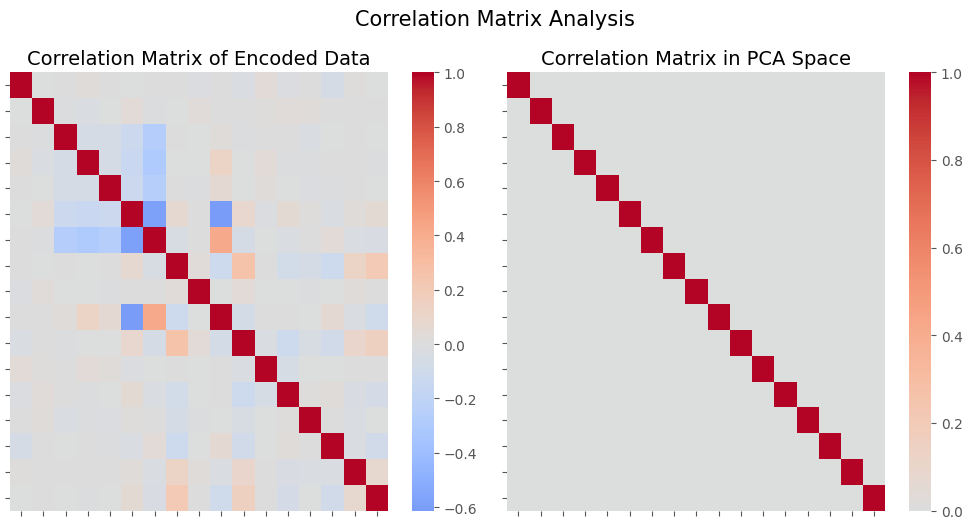

In [73]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

encoded_corr_matrix = plot_corr_matrix_encoded_data(pca_pipeline, X_student_cleaned, ax=axes[0])

pca_corr_matrix = plot_corr_matrix_pca(pca_pipeline, X_student_cleaned, ax=axes[1])

plt.tight_layout()
fig.suptitle('Correlation Matrix Analysis', y=1.05, size=15)
plt.show()

In [76]:
def plot_learning_curves(X: pd.DataFrame,
                         y: pd.Series) -> None:
    """
    Plot learning curves for multiple models.
    :param X: Feature DataFrame.
    :param y: Target Series.
    """

    models = {
        'Random Forest': RandomForestClassifier(),
        'XGBoost': XGBClassifier(eval_metric="logloss", use_label_encoder=False, verbosity=0),
        'Logistic Regression': LogisticRegression(),
        'SVM (RBF Kernel)': SVC(kernel='rbf')
    }

    column_transformer = ColumnTransformer(
        [('encoder', OneHotEncoder(drop='first', max_categories=10, handle_unknown="ignore"),
          X.select_dtypes(include='object').columns)],
        remainder='passthrough',
        sparse_threshold=0
    )

    pipelines = {
        'Random Forest': make_pipeline(column_transformer, models['Random Forest']),
        'XGBoost': make_pipeline(column_transformer, models['XGBoost']),
        'Logistic Regression': make_pipeline(column_transformer, StandardScaler(),
                                             PCA(), models['Logistic Regression']),
        'SVM (RBF Kernel)': make_pipeline(column_transformer, StandardScaler(),
                                          PCA(), models['SVM (RBF Kernel)'])
    }

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    for idx, (model_name, pipeline) in enumerate(tqdm(pipelines.items(), desc='Computing Learning Curves')):
        train_sizes, train_scores, val_scores = learning_curve(
            pipeline, X, y, cv=5, scoring='matthews_corrcoef', train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1)

        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        val_scores_mean = np.mean(val_scores, axis=1)
        val_scores_std = np.std(val_scores, axis=1)

        ax = axes[idx]
        ax.set_title(f'Learning Curve - {model_name}', fontsize=12)
        ax.set_xlabel("Training size")
        ax.set_ylabel("Score")
        ax.grid()

        ax.fill_between(train_sizes,
                        train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std,
                        alpha=0.1, color="r")
        ax.fill_between(train_sizes,
                        val_scores_mean - val_scores_std,
                        val_scores_mean + val_scores_std,
                        alpha=0.1, color="g")
        ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training MCC")
        ax.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Validation MCC")

        ax.legend(loc="best")

    plt.tight_layout()
    fig.suptitle('Learning Curves', y=1.02, size=15)
    plt.show()

Computing Learning Curves:   0%|          | 0/4 [00:00<?, ?it/s]

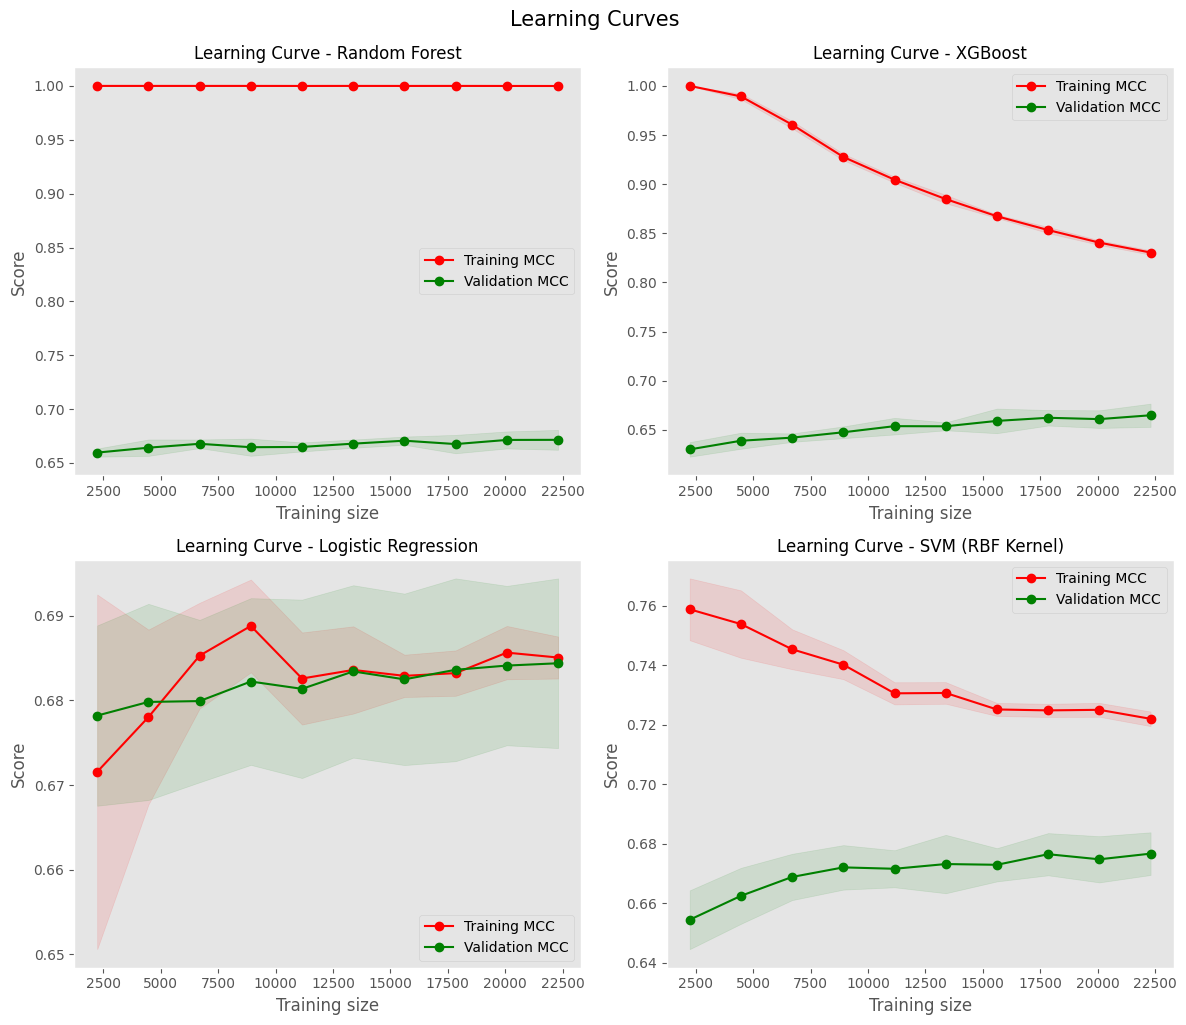

In [83]:
plot_learning_curves(X_student_cleaned, y_student)

In [31]:
def optimize_pca_components(X: pd.DataFrame,
                            y: pd.Series,
                            model: BaseEstimator,
                            min_frequency: float = 0.05,
                            max_components: int = None,
                            cv: int = 5) -> Tuple[int, float,
                                           Dict[int, Tuple[float, float, float, float]]]:
    """
    Optimize the number of components for PCA in a pipeline with a given model using MCC.

    :param X: Feature DataFrame.
    :param y: Target Series.
    :param model: Estimator to use in the pipeline.
    :param min_frequency: Minimum frequency parameter for OneHotEncoder.
    :param max_components: Maximum number of PCA components to test (default: number of features in X).
    :param cv: Number of cross-validation folds (default: 5).
    :return: Tuple of (best_n_components, best_score, scores_dict).
    """

    if max_components is None:
        max_components = X.shape[1]

    column_transformer = ColumnTransformer(
        [('encoder', OneHotEncoder(drop='first', min_frequency=min_frequency, handle_unknown="ignore"),
          X.select_dtypes(include='object').columns)],
        remainder='passthrough',
        sparse_threshold=0
    )

    scores = {}
    train_mean_scores = []
    train_std_scores = []
    val_mean_scores = []
    val_std_scores = []

    for n_components in tqdm(range(1, max_components + 1), desc='Optimizing PCA Components'):
        pipeline = Pipeline([
            ('preprocessor', column_transformer),
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=n_components)),
            ('model', model)
        ])
        cv_results = cross_validate(pipeline, X, y, cv=cv, scoring="matthews_corrcoef", return_train_score=True, n_jobs=-1)
        train_scores = cv_results['train_score']
        val_scores = cv_results['test_score']
        
        train_mean = np.mean(train_scores)
        train_std = np.std(train_scores)
        val_mean = np.mean(val_scores)
        val_std = np.std(val_scores)
        
        train_mean_scores.append(train_mean)
        train_std_scores.append(train_std)
        val_mean_scores.append(val_mean)
        val_std_scores.append(val_std)

        scores[n_components] = (train_mean, train_std, val_mean, val_std)

    best_n_components = max(scores, key=lambda k: scores[k][2])
    best_score = scores[best_n_components][2]

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_components + 1), train_mean_scores, marker='o', label='Train MCC Score', color='blue')
    plt.fill_between(range(1, max_components + 1),
                     [m - s for m, s in zip(train_mean_scores, train_std_scores)],
                     [m + s for m, s in zip(train_mean_scores, train_std_scores)],
                     color='blue', alpha=0.2)

    plt.plot(range(1, max_components + 1), val_mean_scores, marker='o', label='Validation MCC Score', color='orange')
    plt.fill_between(range(1, max_components + 1),
                     [m - s for m, s in zip(val_mean_scores, val_std_scores)],
                     [m + s for m, s in zip(val_mean_scores, val_std_scores)],
                     color='orange', alpha=0.2)

    plt.xlabel('Number of PCA Components')
    plt.ylabel('MCC Score')
    plt.title('Optimization of PCA Components using MCC')
    plt.grid()
    plt.legend(loc='best')
    plt.show()

    return best_n_components, best_score, scores

Optimizing PCA Components:   0%|          | 0/13 [00:00<?, ?it/s]

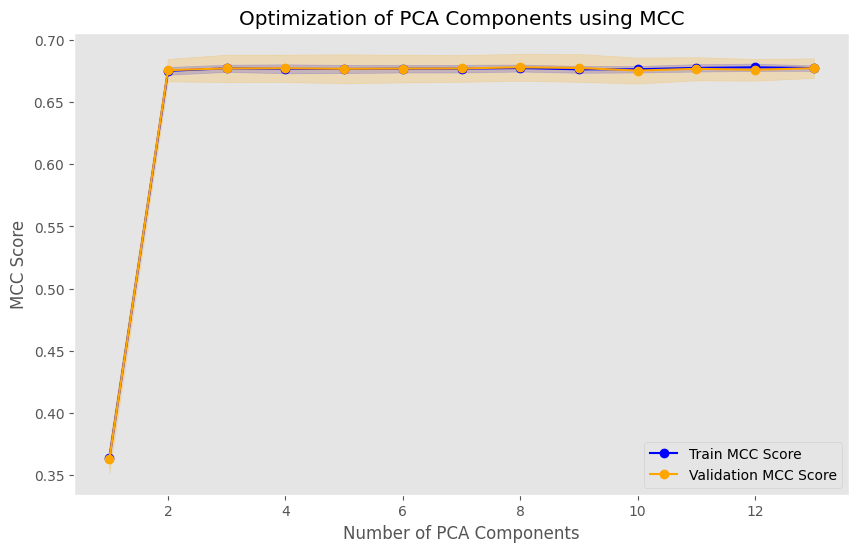

In [78]:
_ = optimize_pca_components(X_student_cleaned, y_student, LogisticRegression(), min_frequency=0.05)

In [79]:
def optimize_pca_and_encoder(X: pd.DataFrame,
                             y: pd.Series,
                             model: BaseEstimator, 
                             min_frequency_range: np.ndarray = np.linspace(0.01, 0.5, 10),
                             max_components: int = None,
                             cv: int = 5) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Optimize both n_components for PCA and min_frequency for OneHotEncoder with a given model using MCC.
    Displays a contour plot of MCC scores.

    :param X: Feature DataFrame.
    :param y: Target Series.
    :param model: Estimator to use in the pipeline.
    :param min_frequency_range: Range of min_frequency values to test (default: np.linspace(0.01, 0.5, 10)).
    :param max_components: Maximum number of PCA components to test (default: 1 to number of features in X).
    :param cv: Number of cross-validation folds (default: 5).
    :return: Tuple of (min_frequency_values, n_components_values, scores_grid).
    """

    if max_components is None:
        max_components = min(X.shape[1], X.shape[0] * (cv - 1) // cv)

    n_components_range = range(1, max_components + 1)
    scores_grid = []

    for min_frequency in tqdm(min_frequency_range, desc='Optimizing PCA and Encoder'):
        row_scores = []
        for n_components in n_components_range:
            column_transformer = ColumnTransformer(
                [('encoder', OneHotEncoder(drop='first', min_frequency=min_frequency, handle_unknown="ignore"),
                  X.select_dtypes(include='object').columns)],
                remainder='passthrough',
                sparse_threshold=0
            )
            pipeline = Pipeline([
                ('preprocessor', column_transformer),
                ('scaler', StandardScaler()),
                ('pca', PCA(n_components=n_components)),
                ('model', model)
            ])
            try:
                score = np.mean(cross_val_score(pipeline, X, y, cv=cv, scoring="matthews_corrcoef", n_jobs=-1))
                row_scores.append(score)
            except ValueError:
                row_scores.append(np.nan)
        scores_grid.append(row_scores)

    min_frequency_values = np.array(min_frequency_range)
    n_components_values = np.array(list(n_components_range))
    scores_grid = np.array(scores_grid)

    X_mesh, Y_mesh = np.meshgrid(n_components_values, min_frequency_values)

    plt.figure(figsize=(10, 8))
    contour = plt.contourf(X_mesh, Y_mesh, scores_grid, levels=50, cmap='viridis_r', alpha=0.8)
    plt.colorbar(contour, label="MCC Score")
    plt.xlabel("Number of PCA Components")
    plt.ylabel("Min Frequency (OneHotEncoder)")
    plt.title("Optimization of n_components and min_frequency (MCC)")
    plt.show()

    return min_frequency_values, n_components_values, scores_grid

Optimizing PCA and Encoder:   0%|          | 0/12 [00:00<?, ?it/s]

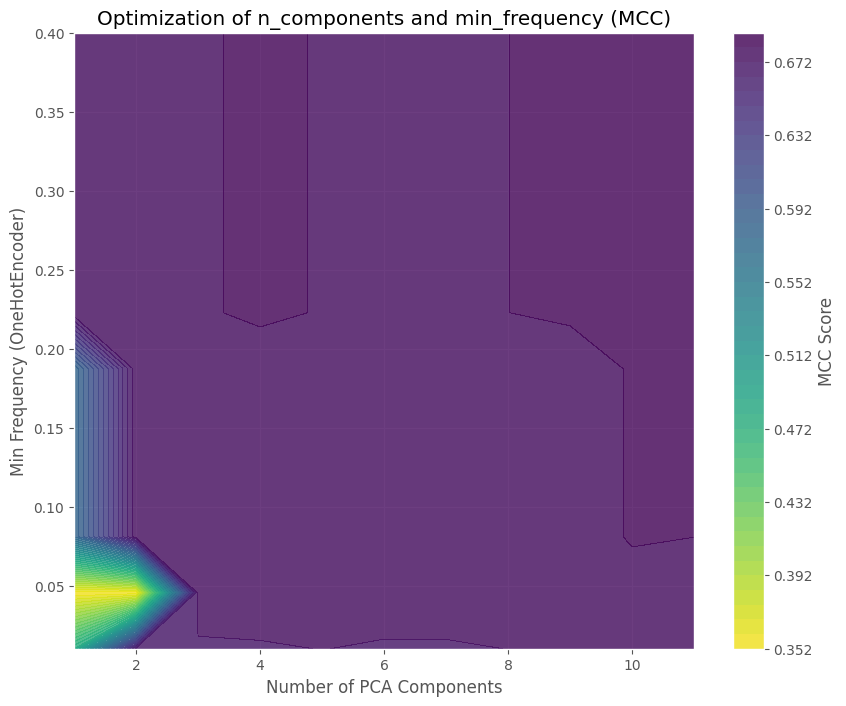

In [80]:
_ = optimize_pca_and_encoder(X_student_cleaned, y_student, LogisticRegression(), min_frequency_range=np.linspace(0.01, 0.4, 12), max_components=11)

In [32]:
def optimize_model_with_optuna(
    trial: optuna.Trial,
    X: pd.DataFrame,
    y: pd.Series,
    model_pipeline: Union[Pipeline, ImbPipeline],
    param_generator: Callable[[optuna.Trial],Dict[str, any]],
    scoring_metric: str = "matthews_corrcoef",
    cv: int = 5) -> float:
    """
    Optimize a model pipeline using Optuna.

    :param trial: The Optuna trial.
    :param X: The features.
    :param y: The target.
    :param model_pipeline: The model pipeline to optimize.
    :param param_generator: The function to generate the parameters.
    :param scoring_metric: The scoring metric.
    :param cv: The number of cross-validation folds.
    :return: The score.
    """

    param_grid = param_generator(trial)

    model_pipeline.set_params(**param_grid)

    try:
        scores = cross_val_score(
            model_pipeline,
            X,
            y,
            cv=cv,
            scoring=scoring_metric,
            n_jobs=-1
        )
    except Exception:
        return 0.0

    return scores.mean()

In [57]:
def optimize_logistic_regression_with_optuna(trial: optuna.Trial,
                                             X: Union[pd.DataFrame, np.ndarray],
                                             y: Union[pd.Series, np.ndarray],
                                             balanced: bool = False,
                                             oversampling: bool = False) -> float:
    """
    Optimize a logistic regression model using Optuna.

    :param trial: The Optuna trial.
    :param X: The features.
    :param y: The target.
    :param balanced: Whether to use balanced class weights.
    :param oversampling: Whether to use oversampling.
    :return: The score.
    """

    if oversampling:
        model_pipeline = ImbPipeline([
            ('columntransformer', make_column_transformer(
                (OneHotEncoder(drop='first', handle_unknown='ignore'),
                 X.select_dtypes(include='object').columns),
                remainder='passthrough',
                sparse_threshold=0
            )),
            ('smote', SMOTE(random_state=42)),
            ('pca', PCA()),
            ('logisticregression', LogisticRegression(class_weight='balanced' if balanced else None))
        ])

        param_generator_logistic_regression = lambda trial: {
            'columntransformer__onehotencoder__min_frequency': trial.suggest_float('min_frequency', 0.01, 0.5),
            'pca__n_components': trial.suggest_int('n_components', 1, min(X_student_cleaned.shape[1], 11)),
            'logisticregression__C': trial.suggest_float('C', 1e-5, 1e5, log=True),
            'smote__k_neighbors': trial.suggest_int('k_neighbors', 2, 15),
        }



    else:
        model_pipeline = make_pipeline(
            make_column_transformer(
                (OneHotEncoder(drop='first', handle_unknown='ignore'),
                 X.select_dtypes(include='object').columns),
                remainder='passthrough',
                sparse_threshold=0
            ),
            StandardScaler(),
            PCA(),
            LogisticRegression(class_weight='balanced' if balanced else None)
        )

        param_generator_logistic_regression = lambda trial: {
            'columntransformer__onehotencoder__min_frequency': trial.suggest_float('min_frequency', 0.01, 0.5),
            'pca__n_components': trial.suggest_int('n_components', 1, min(X_student_cleaned.shape[1], 11)),
            'logisticregression__C': trial.suggest_float('C', 1e-5, 1e5, log=True)
        }

    return optimize_model_with_optuna(
        trial,
        X,
        y,
        model_pipeline,
        param_generator_logistic_regression
    )

In [83]:
logistic_regression_study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
logistic_regression_study.optimize(lambda trial: optimize_logistic_regression_with_optuna(trial, X_student_cleaned, y_student),
                                   n_trials=200, show_progress_bar=True)

  0%|          | 0/200 [00:00<?, ?it/s]

In [84]:
logistic_regression_study_dataframe = logistic_regression_study.trials_dataframe()
logistic_regression_study_dataframe.head()

,number,value,datetime_start,datetime_complete,duration,params_C,params_min_frequency,params_n_components,state
0,0,0.680025,2024-12-07 19:58:33.983606,2024-12-07 19:58:34.192362,0 days 00:00:00.208756,208.900470,0.193525,11,COMPLETE
1,1,0.676876,2024-12-07 19:58:34.192985,2024-12-07 19:58:34.393145,0 days 00:00:00.200160,0.000363,0.303343,2,COMPLETE
2,2,0.676144,2024-12-07 19:58:34.393722,2024-12-07 19:58:34.600780,0 days 00:00:00.207058,10.260065,0.038461,10,COMPLETE
3,3,0.678528,2024-12-07 19:58:34.601362,2024-12-07 19:58:34.804388,0 days 00:00:00.203026,50014.798289,0.356956,1,COMPLETE
4,4,0.678757,2024-12-07 19:58:34.804934,2024-12-07 19:58:35.005897,0 days 00:00:00.200963,0.000658,0.417897,3,COMPLETE


In [85]:
def plot_optuna_study(study: optuna.study.Study) -> None:
    """
    Plot the Optuna study results.

    :param study: The Optuna study.
    """

    trials_df = study.trials_dataframe(attrs=('params', 'value')).dropna()
    trials_df.columns = [col.replace('params_', '') for col in trials_df.columns]
    
    param_columns = [col for col in trials_df.columns if col != 'value']
    categorical_params = trials_df[param_columns].select_dtypes(exclude=['float64']).columns
    n_params = len(param_columns)
    n_rows = (n_params + 2 - 1) // 2
    
    fig, axes = plt.subplots(n_rows, 2, figsize=(10, n_rows * 4))
    axes = axes.flatten()

    for idx, param in enumerate(param_columns):
        ax = axes[idx]
        if param in categorical_params:
            grouped = trials_df.groupby(param).agg(
                mean_score=('value', 'mean'),
                count=('value', 'size')
            ).reset_index()

            ax.bar(
                grouped[param], grouped['count'], 
                color=plt.cm.coolwarm((grouped['mean_score'] - grouped['mean_score'].min()) /
                                      (grouped['mean_score'].max() - grouped['mean_score'].min())),
                edgecolor='black'
            )

            ax.set_title(f"{param}")
            ax.set_xlabel("Value")
            ax.set_ylabel("Count")
        else:
            _ = ax.scatter(
                trials_df[param], trials_df['value'], 
                c=trials_df['value'], 
                cmap='coolwarm', 
                edgecolor='black', alpha=0.7
            )

            ax.set_title(f"{param}")
            ax.set_xlabel(f"Value")
            ax.set_ylabel("MCC")

    for idx in range(len(param_columns), len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    fig.suptitle(f"Optuna Study Results for {len(trials_df)} iterations", y=1.02, size=15)
    plt.show()

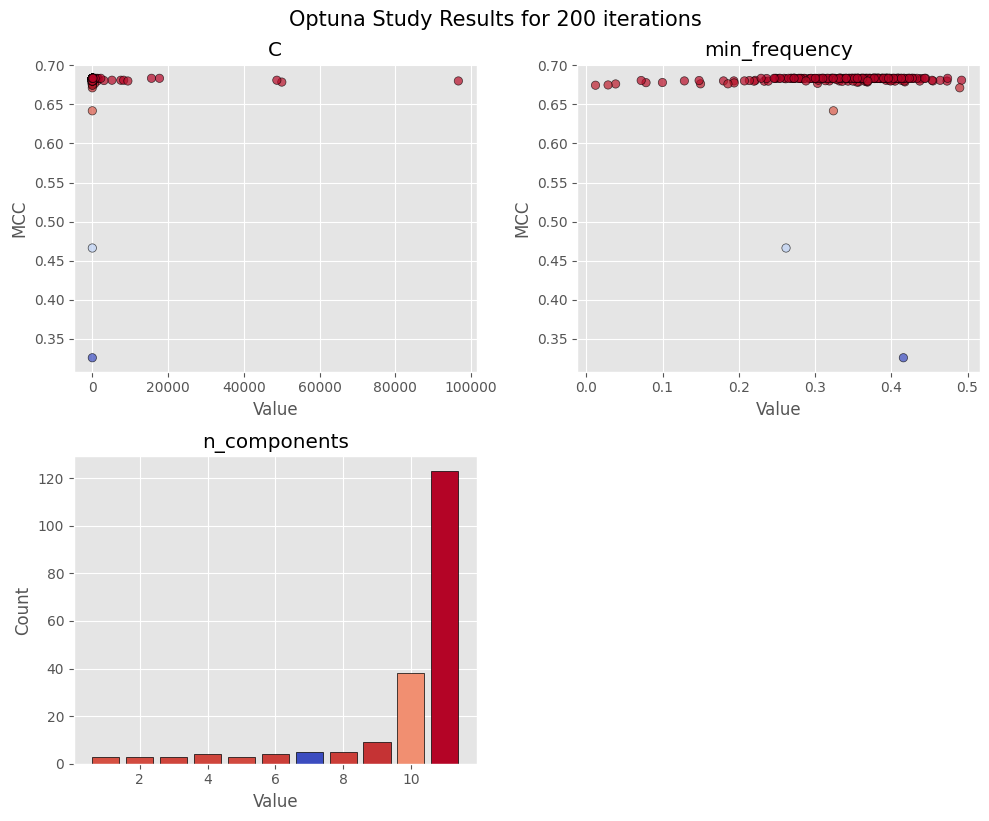

In [86]:
plot_optuna_study(logistic_regression_study)

In [87]:
print(f"Best parameters for Logistic Regression: {logistic_regression_study.best_params} with MCC: {logistic_regression_study.best_value:.4f}")

Best parameters for Logistic Regression: {'min_frequency': 0.2725740820893831, 'n_components': 11, 'C': 32.529643998118466} with MCC: 0.6834


In [58]:
balanced_logistic_regression_study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
balanced_logistic_regression_study.optimize(lambda trial: optimize_logistic_regression_with_optuna(trial, X_student_cleaned, y_student, balanced=True),
                                            n_trials=200, show_progress_bar=True)

  0%|          | 0/200 [00:00<?, ?it/s]

In [89]:
print(f"Best parameters for Balanced Logistic Regression: {balanced_logistic_regression_study.best_params} with MCC: {balanced_logistic_regression_study.best_value:.4f}")

Best parameters for Balanced Logistic Regression: {'min_frequency': 0.2962044537881431, 'n_components': 10, 'C': 0.0003919133475656124} with MCC: 0.6826


In [90]:
logistic_regression_smote_study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
logistic_regression_smote_study.optimize(lambda trial: optimize_logistic_regression_with_optuna(trial, X_student_cleaned, y_student, oversampling=True),
                                         n_trials=200, show_progress_bar=True)

  0%|          | 0/200 [00:00<?, ?it/s]

In [39]:
print(f"Best parameters for Logistic Regression with SMOTE: {logistic_regression_smote_study.best_params} with MCC: {logistic_regression_smote_study.best_value:.4f}")

Best parameters for Logistic Regression with SMOTE: {'min_frequency': 0.10187135234575273, 'n_components': 11, 'C': 0.35418543311506606, 'k_neighbors': 12} with MCC: 0.6831


In [164]:
class NUNSClassifier(BaseEstimator, ClassifierMixin):
    """
    Implementation of the following paper https://arxiv.org/pdf/2110.13048 integrated with sklearn API.
    """

    def __init__(self,
                 pilot_model: BaseEstimator = LogisticRegression(),
                 final_model: BaseEstimator = LogisticRegression(),
                 final_model_name_if_pipeline: str = None,
                 sampling_rate: float = 0.1,
                 random_state: int = 42) -> None:
        """
        Non-Uniform Sampling and Log Odds Correction Classifier with customizable models.
        
        :param pilot_model: Model used for scoring samples in the pilot phase (must support predict_proba).
        :param final_model: Model used for the final classification (must support sample_weight).
        :param final_model_name_if_pipeline: Name of the final model if it is a pipeline (we need to access the model).
        :param sampling_rate: The sampling rate for the minority class.
        :param random_state: The random state for reproducibility.
        """

        self.pilot_model = pilot_model
        self.final_model = final_model
        self.final_model_name_if_pipeline = final_model_name_if_pipeline
        if isinstance(self.final_model, Pipeline) and final_model_name_if_pipeline is None:
            raise ValueError("final_model_name_if_pipeline must be specified for pipelines as final_model.")
        self.sampling_rate = sampling_rate
        self.random_state = random_state
        self.__unbalanced_class = None
        self.classes_ = None
        np.random.seed(random_state)

    def __uniform_sample(self,
                         data: pd.DataFrame,
                         labels: pd.Series
                         ) -> Tuple[pd.DataFrame, np.ndarray]:
        """
        Sample the majority class to balance the dataset.

        :param data: The data to sample.
        :param labels: The labels to sample.
        :return: The balanced data and labels.
        """

        labels = labels.reset_index(drop=True) if isinstance(labels, pd.Series) else labels
        data = data.reset_index(drop=True)

        np.random.seed(self.random_state)
        positive_indices = np.where(labels == 1)[0]
        negative_indices = np.where(labels == 0)[0]

        if len(positive_indices) > len(negative_indices):
            sampled_positive_indices = np.random.choice(positive_indices, size=len(negative_indices), replace=False)
            balanced_indices = np.concatenate([sampled_positive_indices, negative_indices])
            self.__unbalanced_class = 1
        else:
            sampled_negative_indices = np.random.choice(negative_indices, size=len(positive_indices), replace=False)
            balanced_indices = np.concatenate([positive_indices, sampled_negative_indices])
            self.__unbalanced_class = 0

        balanced_data = data.iloc[balanced_indices]
        balanced_labels = labels[balanced_indices]

        return balanced_data, balanced_labels

    def __score_samples(self,
                        pilot_model: BaseEstimator,
                        data: pd.DataFrame) -> np.ndarray:
        """
        Get the class probabilities of the samples.

        :param pilot_model: The model used for scoring the samples.
        :param data: The data to score.
        :return: The class probabilities.
        """

        return pilot_model.predict_proba(data)[:, 1]

    def __weighted_sample(self,
                          data: pd.DataFrame,
                          labels: Union[np.ndarray, pd.Series],
                          probabilities: np.ndarray
                          ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Perform weighted sampling for the minority class.

        :param data: The data to sample.
        :param labels: The labels to sample.
        :param probabilities: The class probabilities.
        :return: Indices of the weighted samples.
        """

        labels = labels.values if isinstance(labels, pd.Series) else labels
        np.random.seed(self.random_state)

        weighted_indices = []
        sampling_probs = []

        if self.__unbalanced_class == 1:
            minor_class_probs = probabilities[labels == 0]
        else:
            minor_class_probs = 1 - probabilities[labels == 1]

        mean_probability = np.mean(minor_class_probs)

        for i in range(len(data)):
            if labels[i] == self.__unbalanced_class:
                p = 1 - probabilities[i] if self.__unbalanced_class == 1 else probabilities[i]
                sampling_prob = self.sampling_rate * p / mean_probability

                if np.random.uniform(0, 1) < sampling_prob:
                    weighted_indices.append(i)
                    sampling_probs.append(sampling_prob)
            else:
                weighted_indices.append(i)
                sampling_probs.append(1.0)

        return np.array(weighted_indices), np.array(sampling_probs)

    def fit(self,
            X: pd.DataFrame,
            y: pd.Series) -> "NUNSClassifier":
        """
        Fit the Non-Uniform Sampling Classifier.

        :param X: The features.
        :param y: The target.
        :return: The fitted model.
        """

        self.classes_ = np.unique(y)

        balanced_X, balanced_y = self.__uniform_sample(X, y)
        
        self.pilot_model.fit(balanced_X, balanced_y)

        probabilities = self.__score_samples(self.pilot_model, X)

        weighted_indices, sampling_probs = self.__weighted_sample(X, y, probabilities)

        weighted_X = X.iloc[weighted_indices]
        weighted_y = y.iloc[weighted_indices]

        weights = 1 / sampling_probs
        if self.final_model_name_if_pipeline is not None:
            self.final_model.fit(weighted_X, weighted_y, **{f"{self.final_model_name_if_pipeline}__sample_weight": weights})
        else:
            self.final_model.fit(weighted_X, weighted_y, sample_weight=weights)

        return self

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        """
        Predict the target.

        :param X: The features.
        :return: The predictions.
        """

        return self.final_model.predict(X)

    def predict_proba(self, X: pd.DataFrame) -> np.ndarray:
        """
        Predict the class probabilities.

        :param X: The features.
        :return: The class probabilities.
        """

        return self.final_model.predict_proba(X)
    
    def score(self,
              X: pd.DataFrame,
              y: pd.Series) -> float:
        """
        Score the model.

        :param X: The features.
        :param y: The target.
        :return: The score.
        """
        predictions = self.predict(X)
        if np.any(np.isnan(predictions)):
            raise ValueError("Model has NaN predictions.")
        return accuracy_score(y, self.predict(X))

In [93]:
def optimize_nuns_with_optuna(trial: optuna.Trial,
                              X: Union[pd.DataFrame, np.ndarray],
                              y: Union[pd.Series, np.ndarray],
                              pilot_model: Optional[Union[LogisticRegression, XGBClassifier, RandomForestClassifier]] = None,
                              final_model: Optional[Union[LogisticRegression, XGBClassifier, RandomForestClassifier]] = None,
                              scoring_metric: str = "matthews_corrcoef",
                              cv: int = 5) -> float:
    """
    Optimize a NUNSClassifier model using Optuna, with configurable pilot and final models.

    :param trial: The Optuna trial.
    :param X: Input features.
    :param y: Target labels.
    :param pilot_model: Predefined pilot model (default: None).
    :param final_model: Predefined final model (default: None).
    :param scoring_metric: Scoring metric (default: "matthews_corrcoef").
    :param cv: Number of cross-validation folds (default: 5).
    :return: The score.
    """

    sampling_rate = trial.suggest_float("sampling_rate", 0.01, 0.5)
    min_frequency = trial.suggest_float("min_frequency", 0.01, 0.4)
    n_components = trial.suggest_int("n_components", 1, min(X.shape[1], 11))

    if pilot_model is None:
        pilot_model_type = trial.suggest_categorical("pilot_model_type", ["logistic", "xgboost", "random_forest"])
        if pilot_model_type == "logistic":
            pilot_model_C = trial.suggest_float("pilot_model__C", 1e-5, 1e5, log=True)
            pilot_model = LogisticRegression(C=pilot_model_C)
        elif pilot_model_type == "xgboost":
            pilot_model = XGBClassifier(
                n_estimators=trial.suggest_int("pilot_model__n_estimators", 50, 300),
                max_depth=trial.suggest_int("pilot_model__max_depth", 3, 10),
                learning_rate=trial.suggest_float("pilot_model__learning_rate", 0.01, 0.3)
            )
        elif pilot_model_type == "random_forest":
            pilot_model = RandomForestClassifier(
                n_estimators=trial.suggest_int("pilot_model__n_estimators", 50, 300),
                max_depth=trial.suggest_int("pilot_model__max_depth", 3, 10),
                min_samples_split=trial.suggest_int("pilot_model__min_samples_split", 2, 10)
            )
    else:
        if isinstance(pilot_model, LogisticRegression):
            pilot_model.C = trial.suggest_float("pilot_model__C", 1e-5, 1e5, log=True)
        elif isinstance(pilot_model, XGBClassifier):
            pilot_model.set_params(
                n_estimators=trial.suggest_int("pilot_model__n_estimators", 50, 300),
                max_depth=trial.suggest_int("pilot_model__max_depth", 3, 10),
                learning_rate=trial.suggest_float("pilot_model__learning_rate", 0.01, 0.3)
            )
        elif isinstance(pilot_model, RandomForestClassifier):
            pilot_model.set_params(
                n_estimators=trial.suggest_int("pilot_model__n_estimators", 50, 300),
                max_depth=trial.suggest_int("pilot_model__max_depth", 3, 10),
                min_samples_split=trial.suggest_int("pilot_model__min_samples_split", 2, 10)
            )

    if final_model is None:
        final_model_type = trial.suggest_categorical("final_model_type", ["logistic", "xgboost", "random_forest"])
        if final_model_type == "logistic":
            final_model_C = trial.suggest_float("final_model__C", 1e-5, 1e5, log=True)
            final_model = LogisticRegression(C=final_model_C)
        elif final_model_type == "xgboost":
            final_model = XGBClassifier(
                n_estimators=trial.suggest_int("final_model__n_estimators", 50, 300),
                max_depth=trial.suggest_int("final_model__max_depth", 3, 10),
                learning_rate=trial.suggest_float("final_model__learning_rate", 0.01, 0.3)
            )
        elif final_model_type == "random_forest":
            final_model = RandomForestClassifier(
                n_estimators=trial.suggest_int("final_model__n_estimators", 50, 300),
                max_depth=trial.suggest_int("final_model__max_depth", 3, 10),
                min_samples_split=trial.suggest_int("final_model__min_samples_split", 2, 10)
            )
    else:
        if isinstance(final_model, LogisticRegression):
            final_model_name_if_pipeline = "logisticregression"
            final_model.C = trial.suggest_float("final_model__C", 1e-5, 1e5, log=True)
        elif isinstance(final_model, XGBClassifier):
            final_model_name_if_pipeline = "xgbclassifier"
            final_model.set_params(
                n_estimators=trial.suggest_int("final_model__n_estimators", 50, 300),
                max_depth=trial.suggest_int("final_model__max_depth", 3, 10),
                learning_rate=trial.suggest_float("final_model__learning_rate", 0.01, 0.3)
            )
        elif isinstance(final_model, RandomForestClassifier):
            final_model_name_if_pipeline = "randomforestclassifier"
            final_model.set_params(
                n_estimators=trial.suggest_int("final_model__n_estimators", 50, 300),
                max_depth=trial.suggest_int("final_model__max_depth", 3, 10),
                min_samples_split=trial.suggest_int("final_model__min_samples_split", 2, 10)
            )

    def build_pipeline(model):
        apply_feature_engineering = not isinstance(model, (RandomForestClassifier, XGBClassifier))

        preprocessing_steps = [make_column_transformer(
            (OneHotEncoder(drop='first', handle_unknown='ignore', min_frequency=min_frequency),
             X.select_dtypes(include='object').columns),
            remainder='passthrough',
            sparse_threshold=0
        )]
        if apply_feature_engineering:
            preprocessing_steps.extend([
                StandardScaler(),
                PCA(n_components=n_components),
                model
            ])

        return make_pipeline(*[step for step in preprocessing_steps])

    pilot_pipeline = build_pipeline(pilot_model)
    final_pipeline = build_pipeline(final_model)

    nuns_model = NUNSClassifier(
        pilot_model=pilot_pipeline,
        final_model=final_pipeline,
        final_model_name_if_pipeline=final_model_name_if_pipeline,
        sampling_rate=sampling_rate
    )

    scores = cross_val_score(
        nuns_model,
        X,
        y,
        cv=cv,
        scoring=scoring_metric,
        n_jobs=-1
    )

    return scores.mean()

In [112]:
logistic_regression_nnus_study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
logistic_regression_nnus_study.optimize(lambda trial: optimize_nuns_with_optuna(trial, X_student_cleaned, y_student, pilot_model=LogisticRegression(), final_model=LogisticRegression()),
               n_trials=200, show_progress_bar=True)

  0%|          | 0/200 [00:00<?, ?it/s]

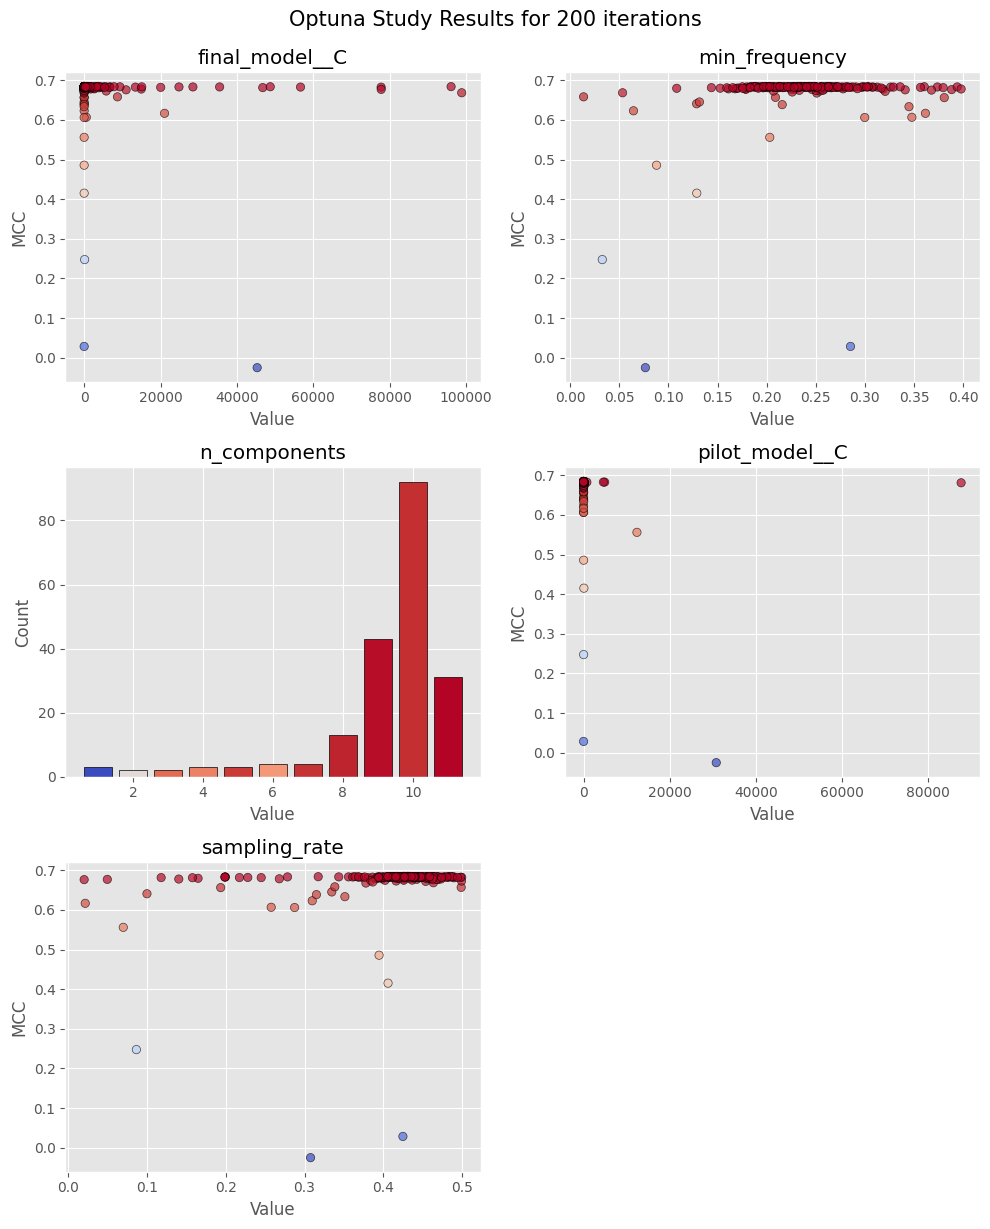

In [95]:
plot_optuna_study(logistic_regression_nnus_study)

In [96]:
print(f"Best parameters for NUNS Classifier: {logistic_regression_nnus_study.best_params} with MCC: {logistic_regression_nnus_study.best_value:.4f}")

Best parameters for NUNS Classifier: {'sampling_rate': 0.43171022031500156, 'min_frequency': 0.23482624306798067, 'n_components': 9, 'pilot_model__C': 0.0010894006731019012, 'final_model__C': 1.2990475814082116} with MCC: 0.6847


In [71]:
def benchmark(pipelines: List[Tuple[str, Union[Pipeline, ImbPipeline]]],
              X_test: pd.DataFrame,
              y_test: pd.Series) -> Dict[str, Dict[str, float]]:
    """
    Benchmark multiple pipelines on test data using various metrics and visualize the results.

    :param pipelines: List of tuples (name, pipeline) to benchmark.
    :param X_test: Test features.
    :param y_test: Test labels.
    :return: A dictionary with metrics for each pipeline.
    """

    metrics = {
        'ROC AUC': roc_auc_score,
        'MCC': matthews_corrcoef,
        'F1 Score': f1_score,
        'Accuracy': accuracy_score,
        'Precision': precision_score,
        'Recall': recall_score
    }

    results = {name: {} for name, _ in pipelines}
    colors = plt.cm.tab10.colors

    dummy_proba = np.full(len(y_test), y_test.mean())
    dummy_metrics = {metric: 0.0 for metric in metrics}
    dummy_metrics['ROC AUC'] = roc_auc_score(y_test, dummy_proba)

    confusion_matrices = {}
    for name, pipeline in pipelines:
        y_pred = pipeline.predict(X_test)
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(pipeline, 'predict_proba') else None

        for metric_name, metric_func in metrics.items():
            if metric_name == 'ROC AUC' and y_pred_proba is not None:
                score = metric_func(y_test, y_pred_proba)
            else:
                score = metric_func(y_test, y_pred)
            results[name][metric_name] = score

        confusion_matrices[name] = confusion_matrix(y_test, y_pred)

    num_metrics = len(metrics)
    cols = 3
    rows = (num_metrics + cols - 1) // cols
    fig1, axes = plt.subplots(rows, cols, figsize=(15, 10), constrained_layout=True)

    for i, (metric_name, metric_func) in enumerate(metrics.items()):
        ax = axes.flatten()[i]

        if metric_name == 'ROC AUC':
            for j, (name, pipeline) in enumerate(pipelines):
                y_pred_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(pipeline, 'predict_proba') else None
                if y_pred_proba is not None:
                    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
                    ax.plot(fpr, tpr, label=f'{name} (AUC={results[name][metric_name]:.4f})',
                            color=colors[j % len(colors)])
            dummy_fpr, dummy_tpr, _ = roc_curve(y_test, dummy_proba)
            ax.plot(dummy_fpr, dummy_tpr, 'k--', label='Dummy Model', color='gray')
            ax.set_xlabel('False Positive Rate')
            ax.set_ylabel('True Positive Rate')
            ax.set_title('ROC Curve')
            ax.legend(loc='lower right')
        else:
            scores = [results[name][metric_name] for name, _ in pipelines]
            names = [name for name, _ in pipelines]
            ax.bar(names, scores, color=colors[:len(scores)])
            ax.set_title(metric_name)
            ax.set_xticklabels(names, rotation=45, ha='right')

        ax.grid(False)

    for j in range(num_metrics, rows * cols):
        axes.flatten()[j].axis('off')

    fig1.suptitle('Model Benchmarking', y=1.02, size=15)

    fig2, cm_axes = plt.subplots(1, len(pipelines), figsize=(5 * len(pipelines), 5), constrained_layout=True)

    if len(pipelines) == 1:
        cm_axes = [cm_axes]  

    for ax, (name, cm) in zip(cm_axes, confusion_matrices.items()):
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
        ax.set_title(f'{name} Confusion Matrix')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')

    fig2.suptitle('Confusion Matrices', y=1.1, size=15)

    plt.show()

    return results

In [67]:
logistic_regression_imbalanced_pipeline = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(drop='first', handle_unknown='ignore', min_frequency=logistic_regression_study.best_params['min_frequency']),
         X_student_cleaned.select_dtypes(include='object').columns),
        remainder='passthrough',
        sparse_threshold=0
    ),
    StandardScaler(),
    PCA(),
    LogisticRegression(C=logistic_regression_study.best_params['C'])
)

logistic_regression_balanced_pipeline = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(drop='first', handle_unknown='ignore', min_frequency=balanced_logistic_regression_study.best_params['min_frequency']),
         X_student_cleaned.select_dtypes(include='object').columns),
        remainder='passthrough',
        sparse_threshold=0
    ),
    StandardScaler(),
    PCA(),
    LogisticRegression(class_weight='balanced', C=balanced_logistic_regression_study.best_params['C'])
)

logistic_regression_smote_pipeline = ImbPipeline([
    ('columntransformer', make_column_transformer(
        (OneHotEncoder(drop='first', handle_unknown='ignore', min_frequency=logistic_regression_smote_study.best_params['min_frequency']),
         X_student_cleaned.select_dtypes(include='object').columns),
        remainder='passthrough',
        sparse_threshold=0
    )),
    ('smote', SMOTE(k_neighbors=logistic_regression_smote_study.best_params['k_neighbors'])),
    ('pca', PCA(n_components=logistic_regression_smote_study.best_params['n_components'])),
    ('logisticregression', LogisticRegression(C=logistic_regression_smote_study.best_params['C']))
])

pilot_pipeline = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(drop='first', handle_unknown='ignore', min_frequency=logistic_regression_nnus_study.best_params['min_frequency']),
         X_student_cleaned.select_dtypes(include='object').columns),
        remainder='passthrough',
        sparse_threshold=0
    ),
    StandardScaler(),
    PCA(n_components=logistic_regression_nnus_study.best_params['n_components']),
    LogisticRegression(C=logistic_regression_nnus_study.best_params['final_model__C'])
)

final_pipeline = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(drop='first', handle_unknown='ignore', min_frequency=logistic_regression_nnus_study.best_params['min_frequency']),
         X_student_cleaned.select_dtypes(include='object').columns),
        remainder='passthrough',
        sparse_threshold=0
    ),
    StandardScaler(),
    PCA(n_components=logistic_regression_nnus_study.best_params['n_components']),
    LogisticRegression(C=logistic_regression_nnus_study.best_params['final_model__C'])
)

nuns_pipeline = NUNSClassifier(
    pilot_model=pilot_pipeline,
    final_model=final_pipeline,
    sampling_rate=logistic_regression_nnus_study.best_params['sampling_rate'],
    final_model_name_if_pipeline="logisticregression"
    )

NameError: name 'logistic_regression_study' is not defined

In [ ]:
pipelines = [
    ("Balanced LogReg", logistic_regression_balanced_pipeline),
    ("Imbalanced LogReg", logistic_regression_imbalanced_pipeline),
    ("LogReg + SMOTE", logistic_regression_smote_pipeline),
    ("LogReg NUNS", nuns_pipeline)
]

for pipe in pipelines:
    pipe[1].fit(X_student_cleaned, y_student)

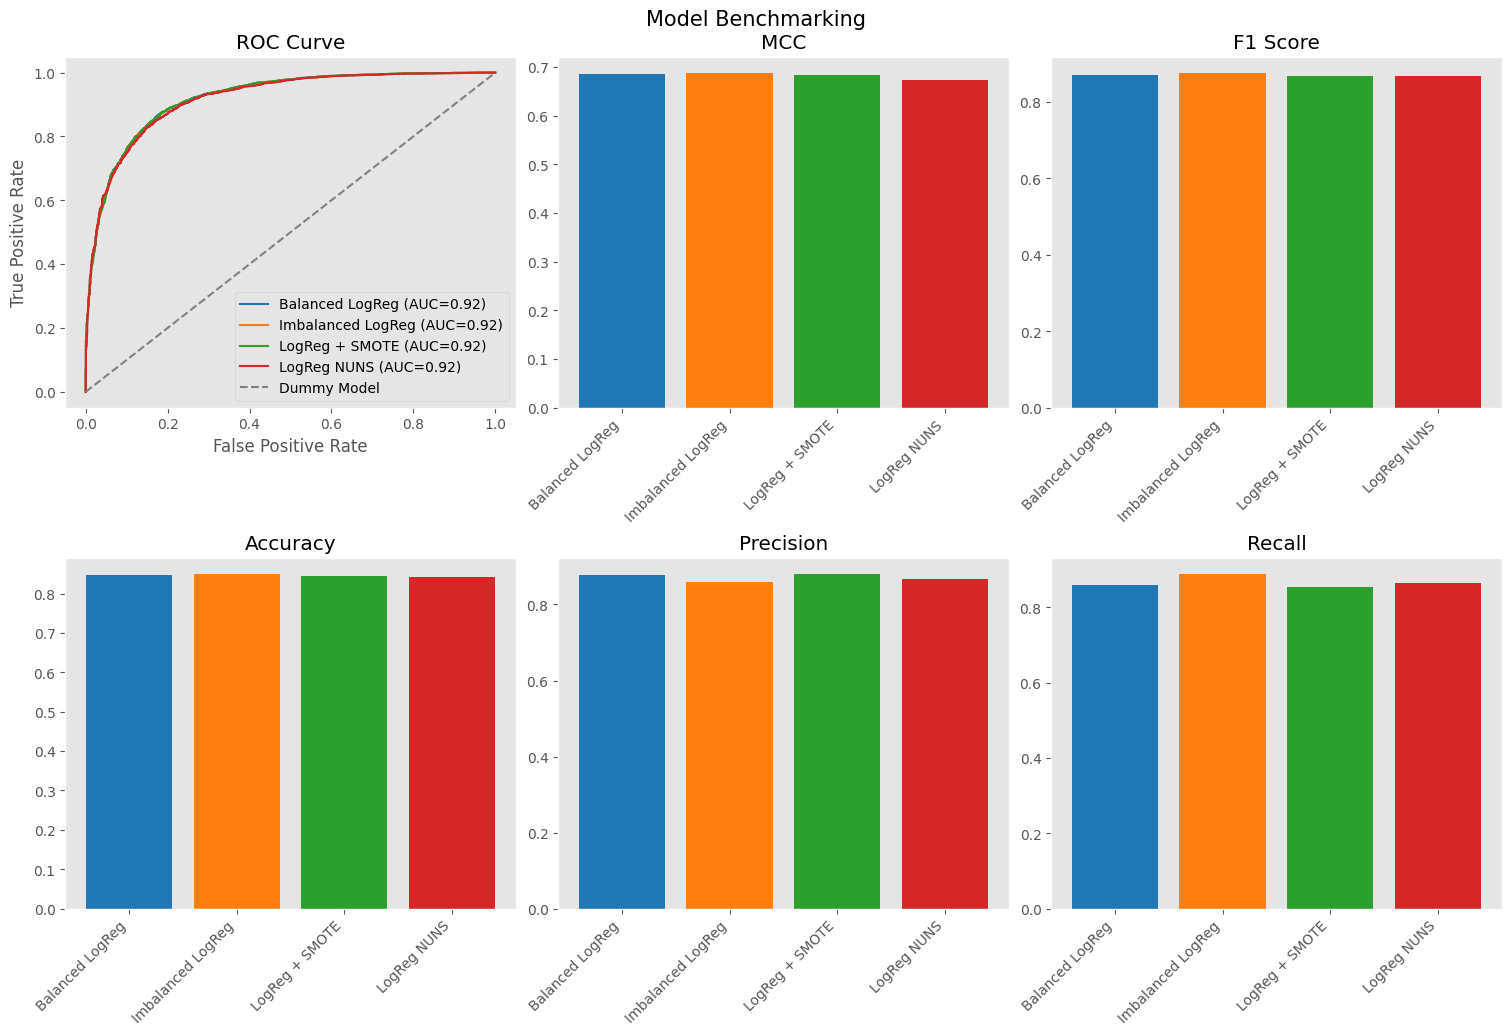

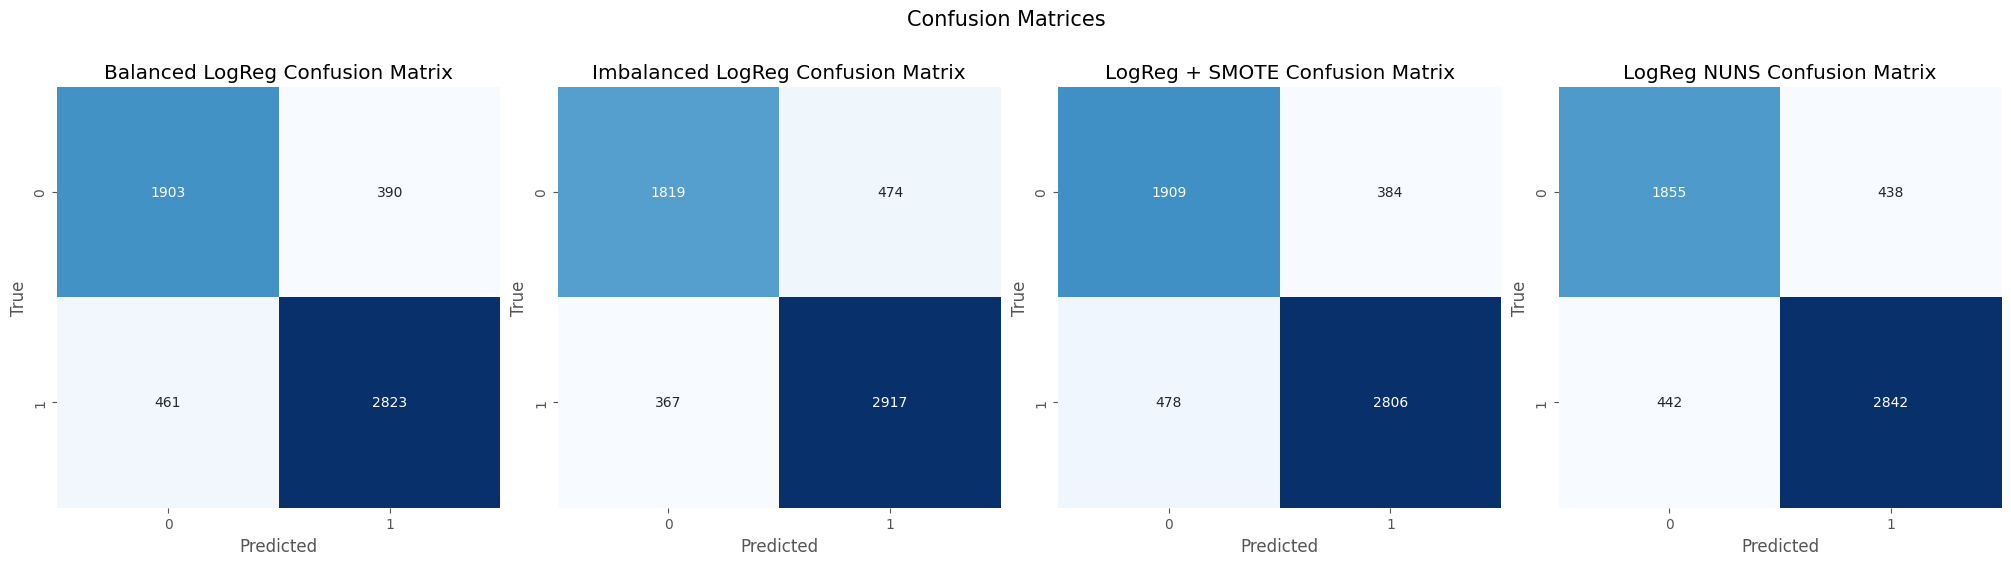

In [162]:
logistic_regression_benchmark = benchmark(pipelines, X_student_test, y_student_test)

In [59]:
def optimize_ensemble_with_optuna(trial: optuna.Trial,
                                  X: Union[pd.DataFrame, np.ndarray],
                                  y: Union[pd.Series, np.ndarray],
                                  model_type: Literal['RandomForest', 'XGBoost', 'Stacking'] = 'RandomForest',
                                  oversampling: bool = False) -> float:
    """
    Optimize an ensemble model (RandomForest, XGBoost, or Stacking) using Optuna.

    :param trial: The Optuna trial.
    :param X: The features.
    :param y: The target.
    :param model_type: The type of ensemble model to optimize ('RandomForest', 'XGBoost', or 'Stacking').
    :param oversampling: Whether to apply SMOTE for oversampling.
    :return: The cross-validated score.
    """

    if model_type not in ['RandomForest', 'XGBoost', 'Stacking']:
        raise ValueError("model_type must be 'RandomForest', 'XGBoost', or 'Stacking'")

    if oversampling:
        model_pipeline = ImbPipeline([
            ('columntransformer', make_column_transformer(
                (OneHotEncoder(drop='first', handle_unknown='ignore'),
                 X.select_dtypes(include='object').columns),
                remainder='passthrough',
                sparse_threshold=0
            )),
            ('smote', SMOTE(random_state=42)),
            ('randomforestclassifier', RandomForestClassifier(random_state=42)) if model_type == 'RandomForest'
                    else ('xgbclassifier', XGBClassifier(use_label_encoder=False,eval_metric='logloss', random_state=42))
        ])
    elif model_type == 'Stacking':
        rf = RandomForestClassifier(random_state=42)
        xgb = XGBClassifier(use_label_encoder=False, random_state=42, eval_metric='logloss')
        meta_model = LogisticRegression()
        model_pipeline = make_pipeline(
            make_column_transformer(
                (OneHotEncoder(drop='first', handle_unknown='ignore'),
                 X.select_dtypes(include='object').columns),
                remainder='passthrough',
                sparse_threshold=0
            ),
            StackingClassifier(estimators=[
                ('rf', rf),
                ('xgb', xgb)
            ], final_estimator=meta_model)
        )
    else:
        model_pipeline = make_pipeline(
            make_column_transformer(
                (OneHotEncoder(drop='first', handle_unknown='ignore'),
                 X.select_dtypes(include='object').columns),
                remainder='passthrough',
                sparse_threshold=0
            ),
            RandomForestClassifier(random_state=42) if model_type == 'RandomForest' else XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
        )

    if model_type == 'RandomForest':
        param_generator = {
            'columntransformer__onehotencoder__min_frequency': trial.suggest_float('min_frequency', 0.01, 0.4),
            'randomforestclassifier__n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'randomforestclassifier__max_depth': trial.suggest_int('max_depth', 3, 20),
            'randomforestclassifier__min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'randomforestclassifier__min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        }
    elif model_type == 'XGBoost':
        param_generator = {
            'columntransformer__onehotencoder__min_frequency': trial.suggest_float('min_frequency', 0.01, 0.4),
            'xgbclassifier__n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'xgbclassifier__max_depth': trial.suggest_int('max_depth', 3, 10),
            'xgbclassifier__learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'xgbclassifier__subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'xgbclassifier__colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        }
    elif model_type == 'Stacking':
        param_generator = {
            'columntransformer__onehotencoder__min_frequency': trial.suggest_float('min_frequency', 0.01, 0.4),
            'stackingclassifier__rf__n_estimators': trial.suggest_int('rf__n_estimators', 50, 300),
            'stackingclassifier__rf__max_depth': trial.suggest_int('rf__max_depth', 3, 20),
            'stackingclassifier__rf__min_samples_split': trial.suggest_int('rf__min_samples_split', 2, 10),
            'stackingclassifier__rf__min_samples_leaf': trial.suggest_int('rf__min_samples_leaf', 1, 5),
            'stackingclassifier__xgb__n_estimators': trial.suggest_int('xgb__n_estimators', 50, 300),
            'stackingclassifier__xgb__max_depth': trial.suggest_int('xgb__max_depth', 3, 10),
            'stackingclassifier__xgb__learning_rate': trial.suggest_float('xgb__learning_rate', 0.01, 0.3),
            'stackingclassifier__xgb__subsample': trial.suggest_float('xgb__subsample', 0.5, 1.0),
            'stackingclassifier__xgb__colsample_bytree': trial.suggest_float('xgb__colsample_bytree', 0.5, 1.0),
        }

    if oversampling:
        param_generator['smote__k_neighbors'] = trial.suggest_int('k_neighbors', 2, 15)

    return optimize_model_with_optuna(
        trial,
        X,
        y,
        model_pipeline,
        lambda _: param_generator
    )

In [60]:
xgbc_studen_study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
xgbc_studen_study.optimize(lambda trial: optimize_ensemble_with_optuna(trial, X_student_cleaned, y_student, model_type='XGBoost'),
                           n_trials=200, show_progress_bar=True)

  0%|          | 0/200 [00:00<?, ?it/s]

In [61]:
print(f"Best parameters for XGBoost: {xgbc_studen_study.best_params} with MCC: {xgbc_studen_study.best_value:.4f}")

Best parameters for XGBoost: {'min_frequency': 0.3276714965917326, 'n_estimators': 164, 'max_depth': 3, 'learning_rate': 0.1421379320445429, 'subsample': 0.9482456038597236, 'colsample_bytree': 0.7323212033322193} with MCC: 0.6865


In [62]:
xgbc_studen_study_with_smote = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
xgbc_studen_study_with_smote.optimize(lambda trial: optimize_ensemble_with_optuna(trial, X_student_cleaned, y_student, model_type='XGBoost', oversampling=True),
                                      n_trials=200, show_progress_bar=True)

  0%|          | 0/200 [00:00<?, ?it/s]

In [63]:
print(f"Best parameters for XGBoost with SMOTE: {xgbc_studen_study_with_smote.best_params} with MCC: {xgbc_studen_study_with_smote.best_value:.4f}")

Best parameters for XGBoost with SMOTE: {'min_frequency': 0.38015414393772595, 'n_estimators': 209, 'max_depth': 3, 'learning_rate': 0.16879968644642687, 'subsample': 0.936361221971285, 'colsample_bytree': 0.5224107553548211, 'k_neighbors': 12} with MCC: 0.6872


In [64]:
rf_student_study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
rf_student_study.optimize(lambda trial: optimize_ensemble_with_optuna(trial, X_student_cleaned, y_student, model_type='RandomForest'),
                            n_trials=200, show_progress_bar=True)

  0%|          | 0/200 [00:00<?, ?it/s]

In [65]:
print(f"Best parameters for RandomForest: {rf_student_study.best_params} with MCC: {rf_student_study.best_value:.4f}")

Best parameters for RandomForest: {'min_frequency': 0.026981668226327988, 'n_estimators': 300, 'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 2} with MCC: 0.6798


In [77]:
stacking_student_study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
stacking_student_study.optimize(lambda trial: optimize_ensemble_with_optuna(trial, X_student_cleaned, y_student, model_type='Stacking'),
                                n_trials=20, show_progress_bar=True)

  0%|          | 0/20 [00:00<?, ?it/s]

In [78]:
print(f"Best parameters for Stacking: {stacking_student_study.best_params} with MCC: {stacking_student_study.best_value:.4f}")

Best parameters for Stacking: {'min_frequency': 0.018027952775362954, 'rf__n_estimators': 293, 'rf__max_depth': 17, 'rf__min_samples_split': 3, 'rf__min_samples_leaf': 1, 'xgb__n_estimators': 96, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.16217936517334897, 'xgb__subsample': 0.7159725093210578, 'xgb__colsample_bytree': 0.645614570099021} with MCC: 0.6830


In [89]:
xgb_student_pipeline = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(drop='first', handle_unknown='ignore', min_frequency=xgbc_studen_study.best_params['min_frequency']),
         X_student_cleaned.select_dtypes(include='object').columns),
        remainder='passthrough',
        sparse_threshold=0
    ),
    XGBClassifier(
        n_estimators=xgbc_studen_study.best_params['n_estimators'],
        max_depth=xgbc_studen_study.best_params['max_depth'],
        learning_rate=xgbc_studen_study.best_params['learning_rate'],
        subsample=xgbc_studen_study.best_params['subsample'],
        colsample_bytree=xgbc_studen_study.best_params['colsample_bytree'],
        use_label_encoder=False,
        eval_metric='logloss'
    )
)

xgb_student_pipeline_with_smote = ImbPipeline([
    ('columntransformer', make_column_transformer(
        (OneHotEncoder(drop='first', handle_unknown='ignore', min_frequency=xgbc_studen_study_with_smote.best_params['min_frequency']),
            X_student_cleaned.select_dtypes(include='object').columns),
        remainder='passthrough',
        sparse_threshold=0
    )),
    ('smote', SMOTE(k_neighbors=xgbc_studen_study_with_smote.best_params['k_neighbors'])),
    ('xgbclassifier', XGBClassifier(
        n_estimators=xgbc_studen_study_with_smote.best_params['n_estimators'],
        max_depth=xgbc_studen_study_with_smote.best_params['max_depth'],
        learning_rate=xgbc_studen_study_with_smote.best_params['learning_rate'],
        subsample=xgbc_studen_study_with_smote.best_params['subsample'],
        colsample_bytree=xgbc_studen_study_with_smote.best_params['colsample_bytree'],
        use_label_encoder=False,
        eval_metric='logloss'
        )
    )
])

rf_student_pipeline = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(drop='first', handle_unknown='ignore', min_frequency=rf_student_study.best_params['min_frequency']),
         X_student_cleaned.select_dtypes(include='object').columns),
        remainder='passthrough',
        sparse_threshold=0
    ),
    RandomForestClassifier(
        n_estimators=rf_student_study.best_params['n_estimators'],
        max_depth=rf_student_study.best_params['max_depth'],
        min_samples_split=rf_student_study.best_params['min_samples_split'],
        min_samples_leaf=rf_student_study.best_params['min_samples_leaf'],
        random_state=42
    )
)

stacking_student_pipeline = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(drop='first', handle_unknown='ignore', min_frequency=stacking_student_study.best_params['min_frequency']),
         X_student_cleaned.select_dtypes(include='object').columns),
        remainder='passthrough',
        sparse_threshold=0
    ),
    StackingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(
                n_estimators=stacking_student_study.best_params['rf__n_estimators'],
                max_depth=stacking_student_study.best_params['rf__max_depth'],
                min_samples_split=stacking_student_study.best_params['rf__min_samples_split'],
                min_samples_leaf=stacking_student_study.best_params['rf__min_samples_leaf'],
                random_state=42
            )),
            ('xgb', XGBClassifier(
                n_estimators=stacking_student_study.best_params['xgb__n_estimators'],
                max_depth=stacking_student_study.best_params['xgb__max_depth'],
                learning_rate=stacking_student_study.best_params['xgb__learning_rate'],
                subsample=stacking_student_study.best_params['xgb__subsample'],
                colsample_bytree=stacking_student_study.best_params['xgb__colsample_bytree'],
                use_label_encoder=False,
                eval_metric='logloss',
                random_state=42
            ))
        ],
        final_estimator=LogisticRegression()
    )
)

pipelines_student = [
    ("XGBoost", xgb_student_pipeline),
    ("XGBoost + SMOTE", xgb_student_pipeline_with_smote),
    ("RandomForest", rf_student_pipeline),
    ('Balanced LogReg', logistic_regression_balanced_pipeline),
    ('Stacking', stacking_student_pipeline)
]

In [90]:
for pipe in pipelines_student:
    pipe[1].fit(X_student_cleaned, y_student)

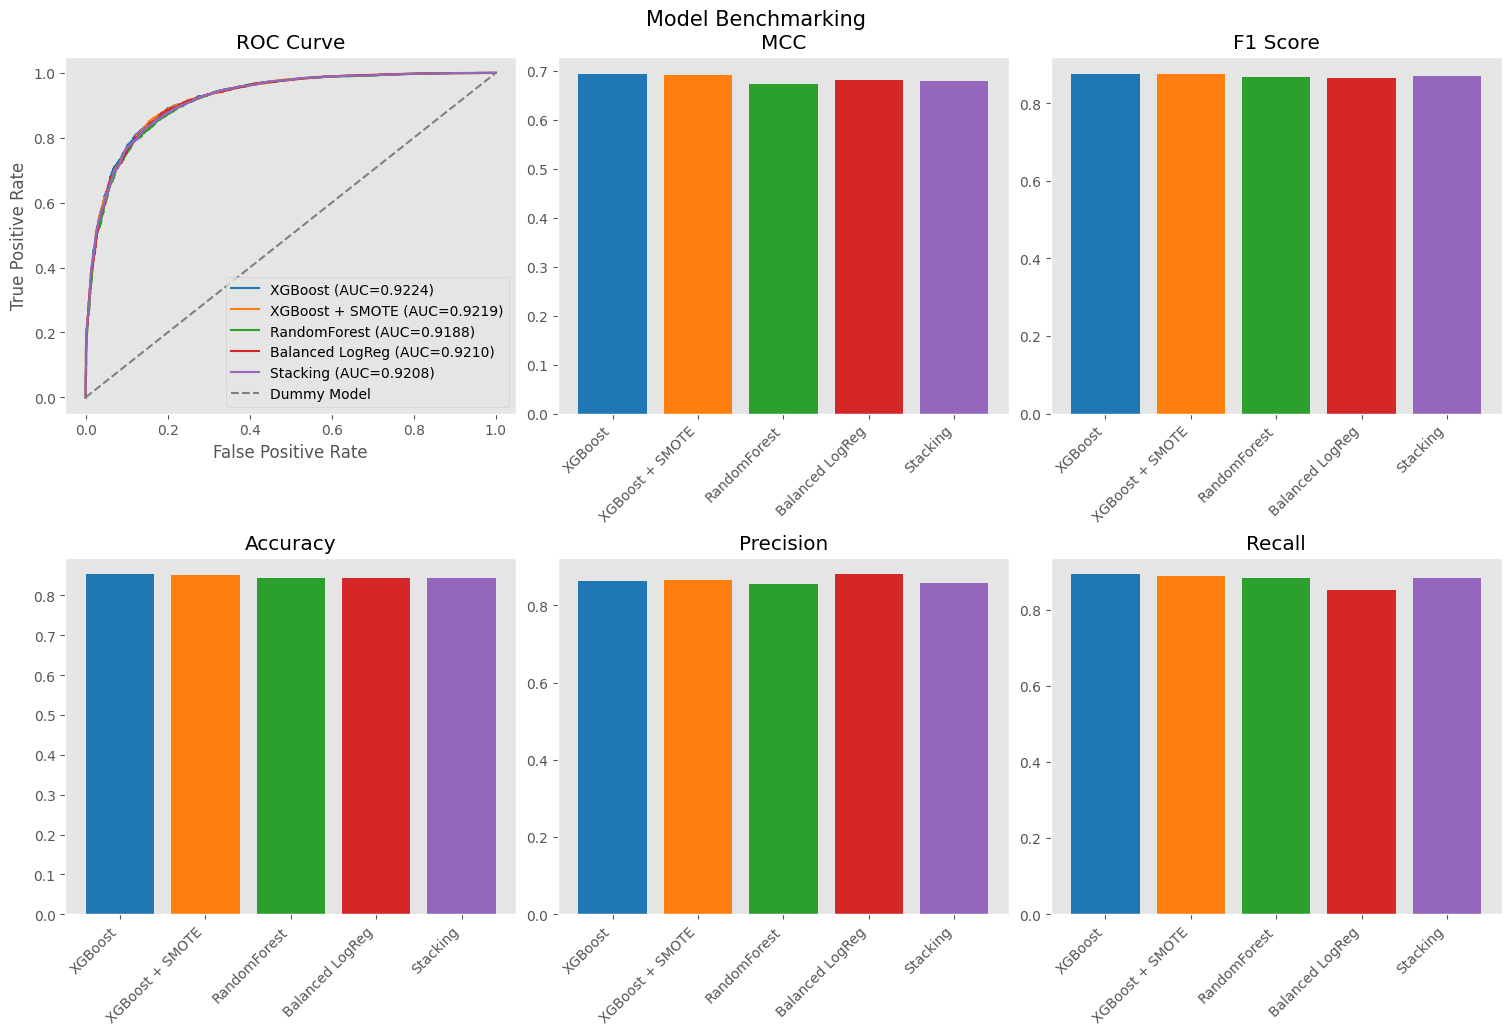

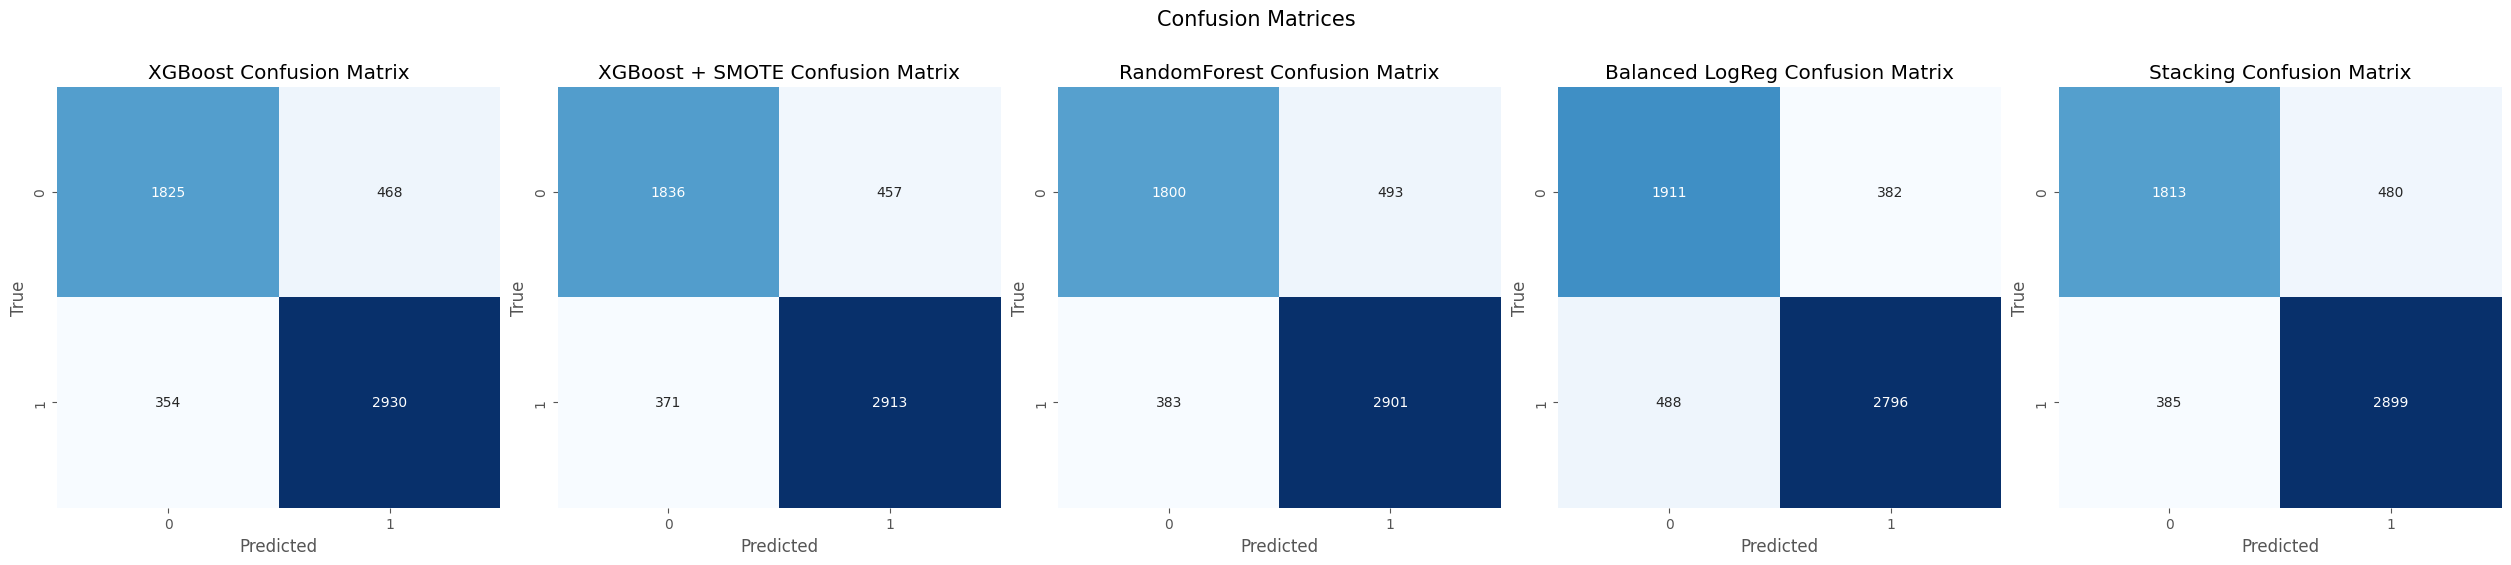

In [91]:
student_results = benchmark(pipelines_student, X_student_test, y_student_test)